## How to Make an ETL Pipeline with AWS 
**Synopsis:**
This document will outline the steps, tools, and scripts used to create an ETL pipeline in AWS.  It will also outline the reasoning for each of the decisions made throughout the process and why these decisions are best practice.  The data used for this project was originally extracted from YouTube and contains information on more than 27000 videos.  The original files include information on number of views, likes, comments, categories, and various other information about each video.  The data was extracted using Youtube's API and the files were stored in JSON and CSV format.  The overarching goal of our pipeline is to convert these files into one data structure (Parquet file) so the information in them can be easily queried using SQL and visualized using BI tools (Amazon QuickSight).  We also want to build the pipeline in a way that will automate these actions whenever new data enters the pipeline.
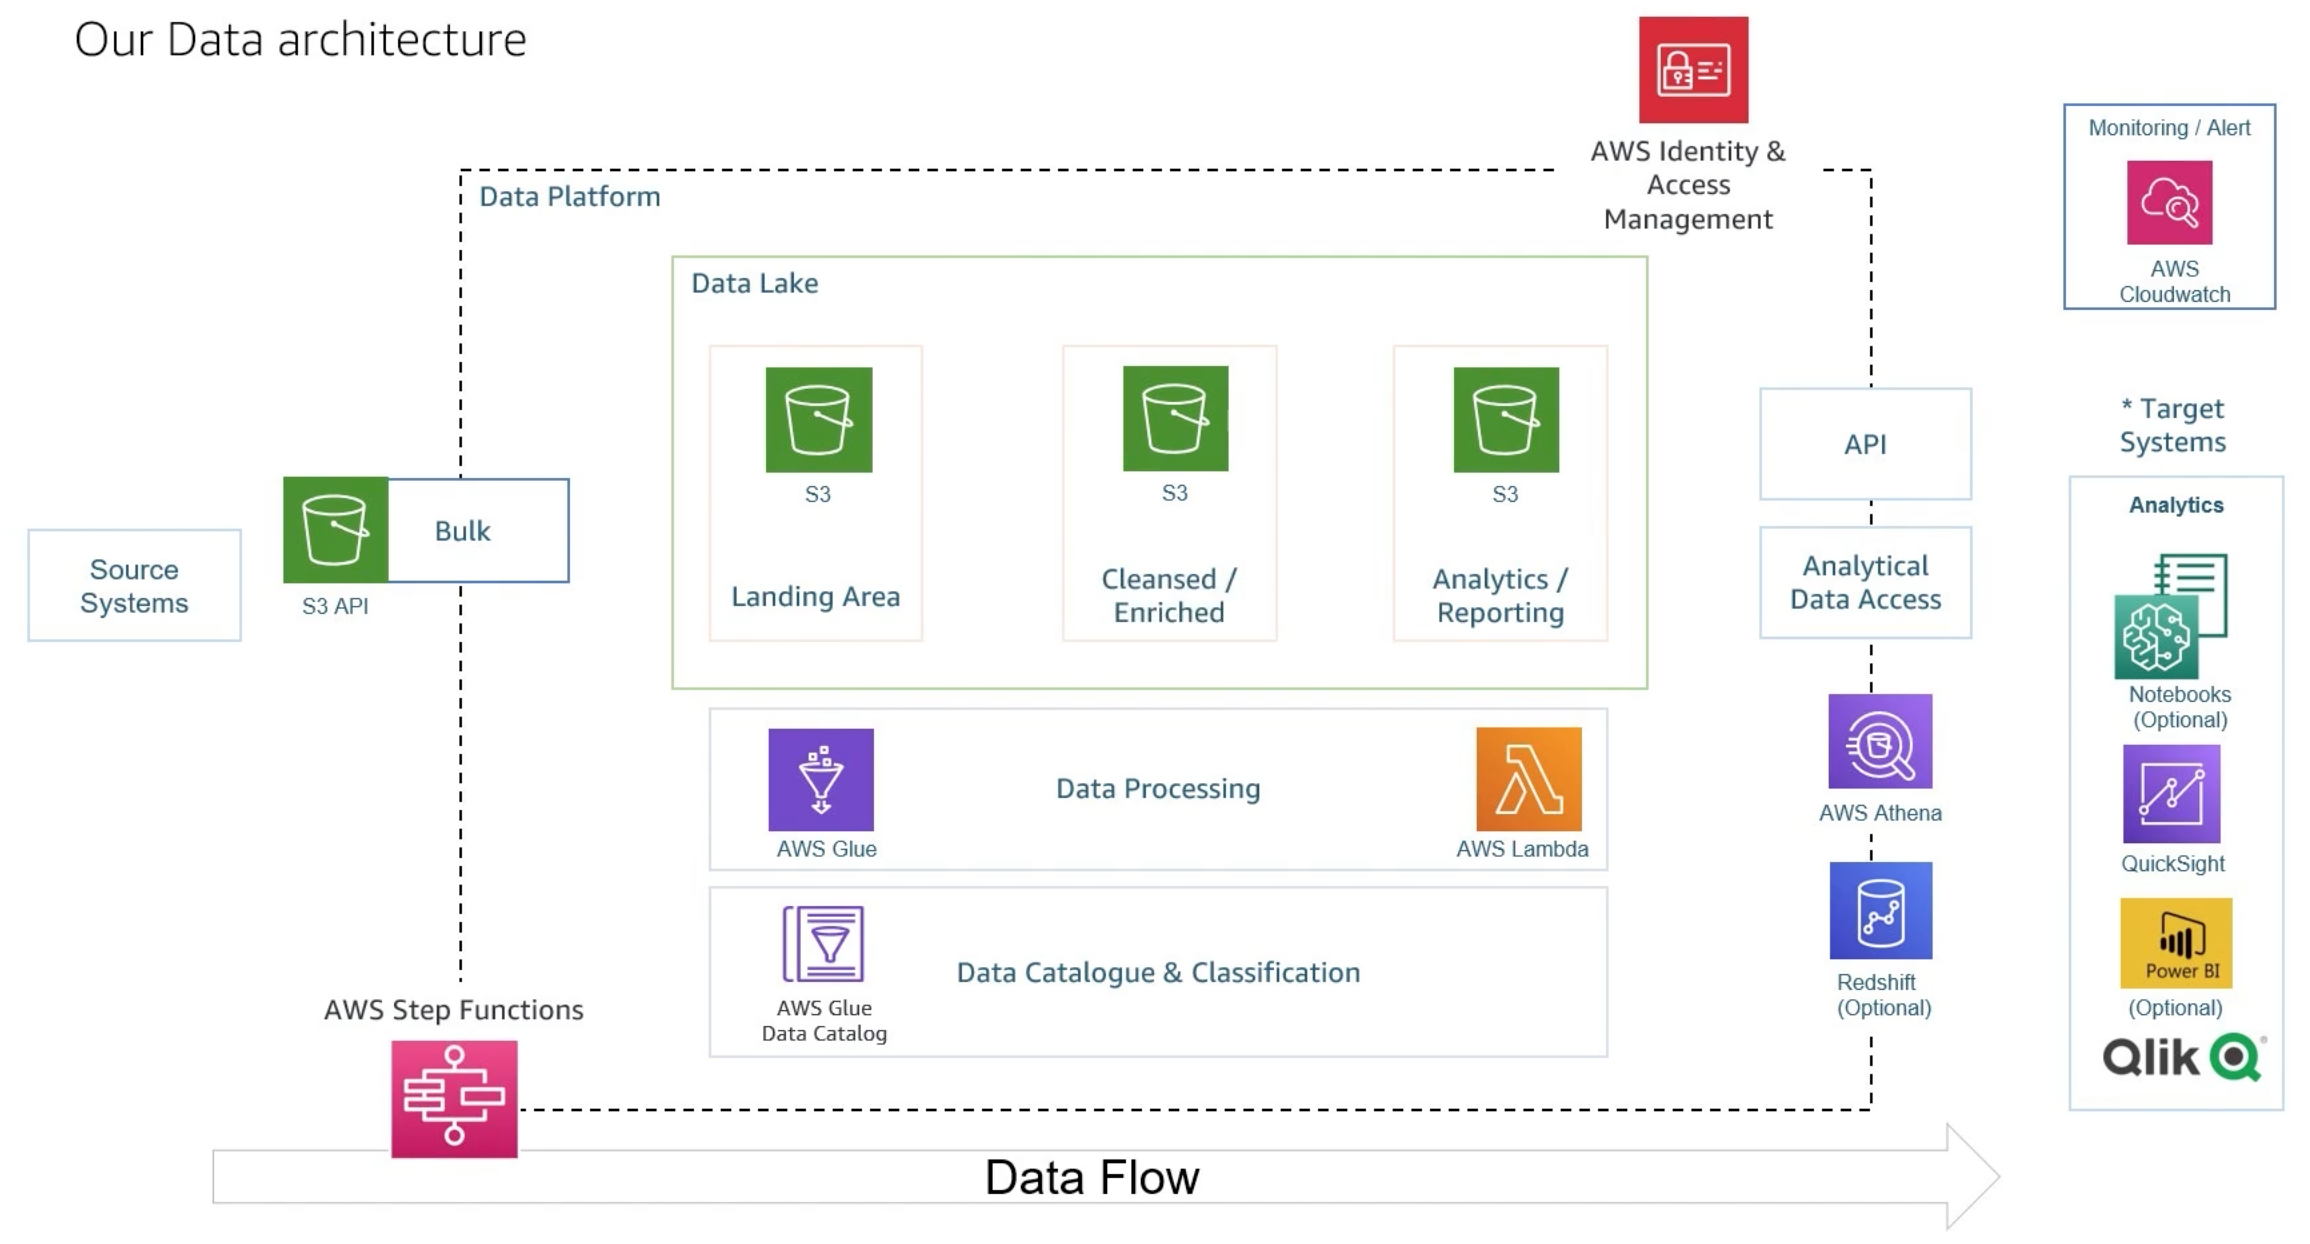
- This visual includes a general idea of the structure of our AWS pipeline and all the tools used.  This visual will become more clear as we move through the steps.

It’s also a good idea to look at the example data we are using for this ETL pipeline as it will help you understand why we are performing each of our steps.  Keep in mind that if you are trying to replicate this pipeline with your own novel data your ETL pipeline and code will vary from ours based.  
- Original Data: https://www.kaggle.com/datasets/datasnaek/youtube-new

## Tools Used 
- **Amazon S3 Buckets**
<p>
An S3 bucket is a public cloud storage resource available in AWS, which users can create and configure to store and retrieve their data. S3 buckets are used to store and manage a wide variety of data, including text and binary files, videos, images, and more. Amazon S3 buckets were used to store the original YouTube data in JSON and CSV format.  New S3 buckets were also made to store the data after it had been transformed into different data structures as it moved down the pipeline. </p>
- **Amazon Lambda Functions**
<p>Amazon Lambda is a serverless computing service offered by Amazon Web Services (AWS). It allows users to run their code in response to events, such as changes to data in an Amazon S3 bucket or a new message arriving in an Amazon Kinesis stream. An Amazon Lambda function is a piece of code that is executed in response to a specific event. This code can be written in a variety of programming languages, including Node.js, Python, Java, and C#. When the event occurs, AWS Lambda automatically runs the code and provides all of the necessary compute resources to execute it. Lambda functions were used to automate the process of converting our original JSON files into parquet format </p>
- **Amazon Glue** 
<p>Amazon Glue is a fully managed extract, transform, and load (ETL) service offered by Amazon Web Services (AWS). It is used to prepare and load data for analytics and machine learning. With Amazon Glue, users can create and run ETL jobs. This allows users to extract data from various data sources, transform it into the desired format, and load it into databases or data lakes for analysis and other uses. Glue Crawler was used to automatically determine the data structures/fields of our original JSON and CSV files and Glue Jobs were created to convert these files into parquet files for later analysis.</p>
- **Amazon Athena**
<p>Amazon Athena is a serverless query service offered by Amazon Web Services (AWS). It allows users to perform SQL queries on data stored in Amazon S3, without the need to set up and manage any infrastructure. With Amazon Athena, users can access and analyze their data in S3 using standard SQL, and get results in seconds.  We used Athena to query out newly created parquet files and perform automated joins that compile all our original files into one easily queryable table.</p>
- **Amazon QuickSight**
<p> Amazon QuickSight is a fast, cloud-powered business intelligence (BI) service offered by Amazon Web Services (AWS). It allows users to create and publish interactive dashboards and visualizations that can be accessed and shared by anyone within an organization. We used QuickSight to create a analytics dashboard visualizing YouTube video metrics. </p>
- **Amazon IAM**
<p>Amazon Web Services (AWS) Identity and Access Management (IAM) is a web service that helps you securely control access to AWS resources. With IAM, you can create and manage AWS users and groups, and use permissions to allow and deny their access to AWS resources. While I was the only person using the various tools and buckets in this ETL pipeline, I included several IAM roles and policies in order to illustrate how this practice would be implemented in a larger business with Data Engineers, Data Scientists, Analysts, and Managers all working on the same project in AWS.  It’s important to create IAM accounts for each of these participants as . project </p>

## Part 1: Creating your S3 Bucket and moving your data into it
**Step 1: Creating your S3 Buckets** Next we will create several s3 buckets to store our original raw data (JSON and CSV files), cleansed data (after JSON and CSV are converted to Azure Parquet files), and the results of our final SQL queries 
- **bigdata-on-youtube-raw-apssoutheast-964154160632-dev** Here is my naming convention for my S3 bucket. This bucket will contain our raw YouTube data (CSV and JSON formats). Notice that the name includes information such as what the project is about, state of the data, AWS server location(apssoutheast = Southeast Asia), and my role (developer).
Below are some more helpful hints on how to on how to configure your bucket. 
    - Select the buckets AWS region carefully as it must be consistent in all the components of your ETL pipeline! if not you will have problems later.
    - Add a tag to your bucket with key=your role (analyst, engineer, etc.) and value= your name
    - Click create bucket!!
- **bigdata-on-youtube-cleansed-apsoutheast-964154160632-dev** s3 bucket for cleansed versions of the raw data (after they have been converted into Azure Parquet files by AWS Lambda and AWS Glue Jobs. We will do this is Part 4)
- **bigdata-on-youtube-assets-apssoutheast-964154160632-dev** s3 bucket for cleansed and joined data.  Once we convert our raw files to parquet files. We will also perform a Join within our pipeline bringing all our parquet files into one file. We can then query all our data easily wiout having to perform joins along with each query. This will save both time and AWS fees. 
**Step 2: Import your original data files to your raw bucket**
There are several ways of importing data to an s3 bucket depending on the location of your data including importing them directly on AWS s3 one-by-one, using an SDK, or transferring them from an existing storage system, like an Oracle database. For this project, our data was originally located in a Kaggle account, so the easiest thing for us to do would be to download the files locally, then used our terminal to bulk upload the local files.  Hopefully you know how to download file to your computer so ill focus on the next step. The following bullets and photo show how to use to terminal to bulk upload files.

- Open your computer terminal and make sure you have the AWS command Line Interface (CLI)downloaded there by running the following prompt in your terminal: "pip install awscli"
- Use the following syntax in your terminal to upload the local YouTube CSV and JSON files to your s3 bucket: "aws s3 cp local_file_path S3_bucket_file_path"
    - Fill in the 'local_file_path' and 's3_bucket_file_path' with the file path leading to your locally downloaded YouTube (or other) data and your s3 bucket path name respectivly. 
    - You can see the 1 line code I used to complete this task below (importing .json to s3 bucket). The "--recursive --exclude'*' --include '*.json'" code tells the terminal to read all .json files into the s3 bucket listed and exclude any other files that don't include a .json. 
    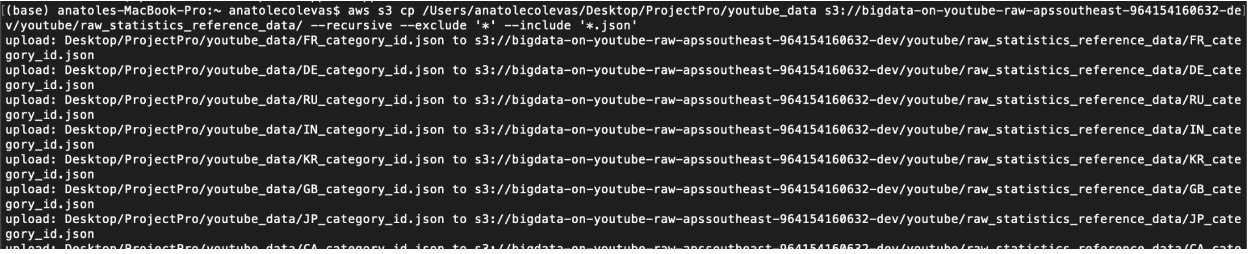
    - You then repeat this process for your .csv files(need to be in separate folder from .jsons as they will be manipulated individually in later steps). You can easily create folders within your buckets in AWS. Just make sure to name them with information that reminds you whats in there!   

 ## Part 2: Create IAM Policies and Roles/Assign permissions to roles.
A very important part of the ETL pipeline creation process is ensuring that each step of the pipeline is secure and can only be accessed by those directly working with or accessing the data at that stage.  You do not want everybody in the organization
to be able to manipulate the pipeline as this will often lead to miscommunication and data processing issues or something worse, like data loss/theft. For this reason it’s important to follow the Least Privileged Principle (LPP). This concept dictates that, “a user or entity should only have access to the specific data, resources and applications needed to complete a required task”. AWS uses Roles and Policies to implement LPP. These resources are managed in the IAM section of the AWS site. Simply type IAM in the AWS search bar to find it.  When creating Policies or Roles in AWS IAM, try to use a naming convention that indicates the function of the Policy or Role clearly. 
- An **AWS POLICY** is a document that defines one or more permissions. These permissions determine what actions a user, group, or service can perform in AWS. AWS policies are written in the JSON format, and they can be attached to an IAM user, group, or role to grant or deny access to AWS resources. For example, a policy might allow a user to perform read and write operations on Amazon S3 buckets, or it might allow a role to launch Amazon EC2 instances. AWS policies help you to manage and control access to your AWS resources.
- An **AWS role** is a way to grant permissions to entities that you trust. An AWS role can be assumed by a user, group, or service that needs to access AWS resources. When an entity assumes a role, it temporarily takes on the permissions that are defined in the role. AWS roles are useful for providing granular access to AWS resources without having to share long-term credentials, such as access keys.
Below I will outline the roles and policies created as part of this ETL pipeline project. 
**Policy List:**
- **bigdata-on-youtube-process-read-write-on-s3** : This policy was built allow read and write actions to be completed for each of the s3 buckets used as part of this pipeline. Policies are written in JSON format. 
I adjusted the JSON to attach the policy to all of the s3 buckets that will be used in this Pipeline. the code used to do so can be seen below. 
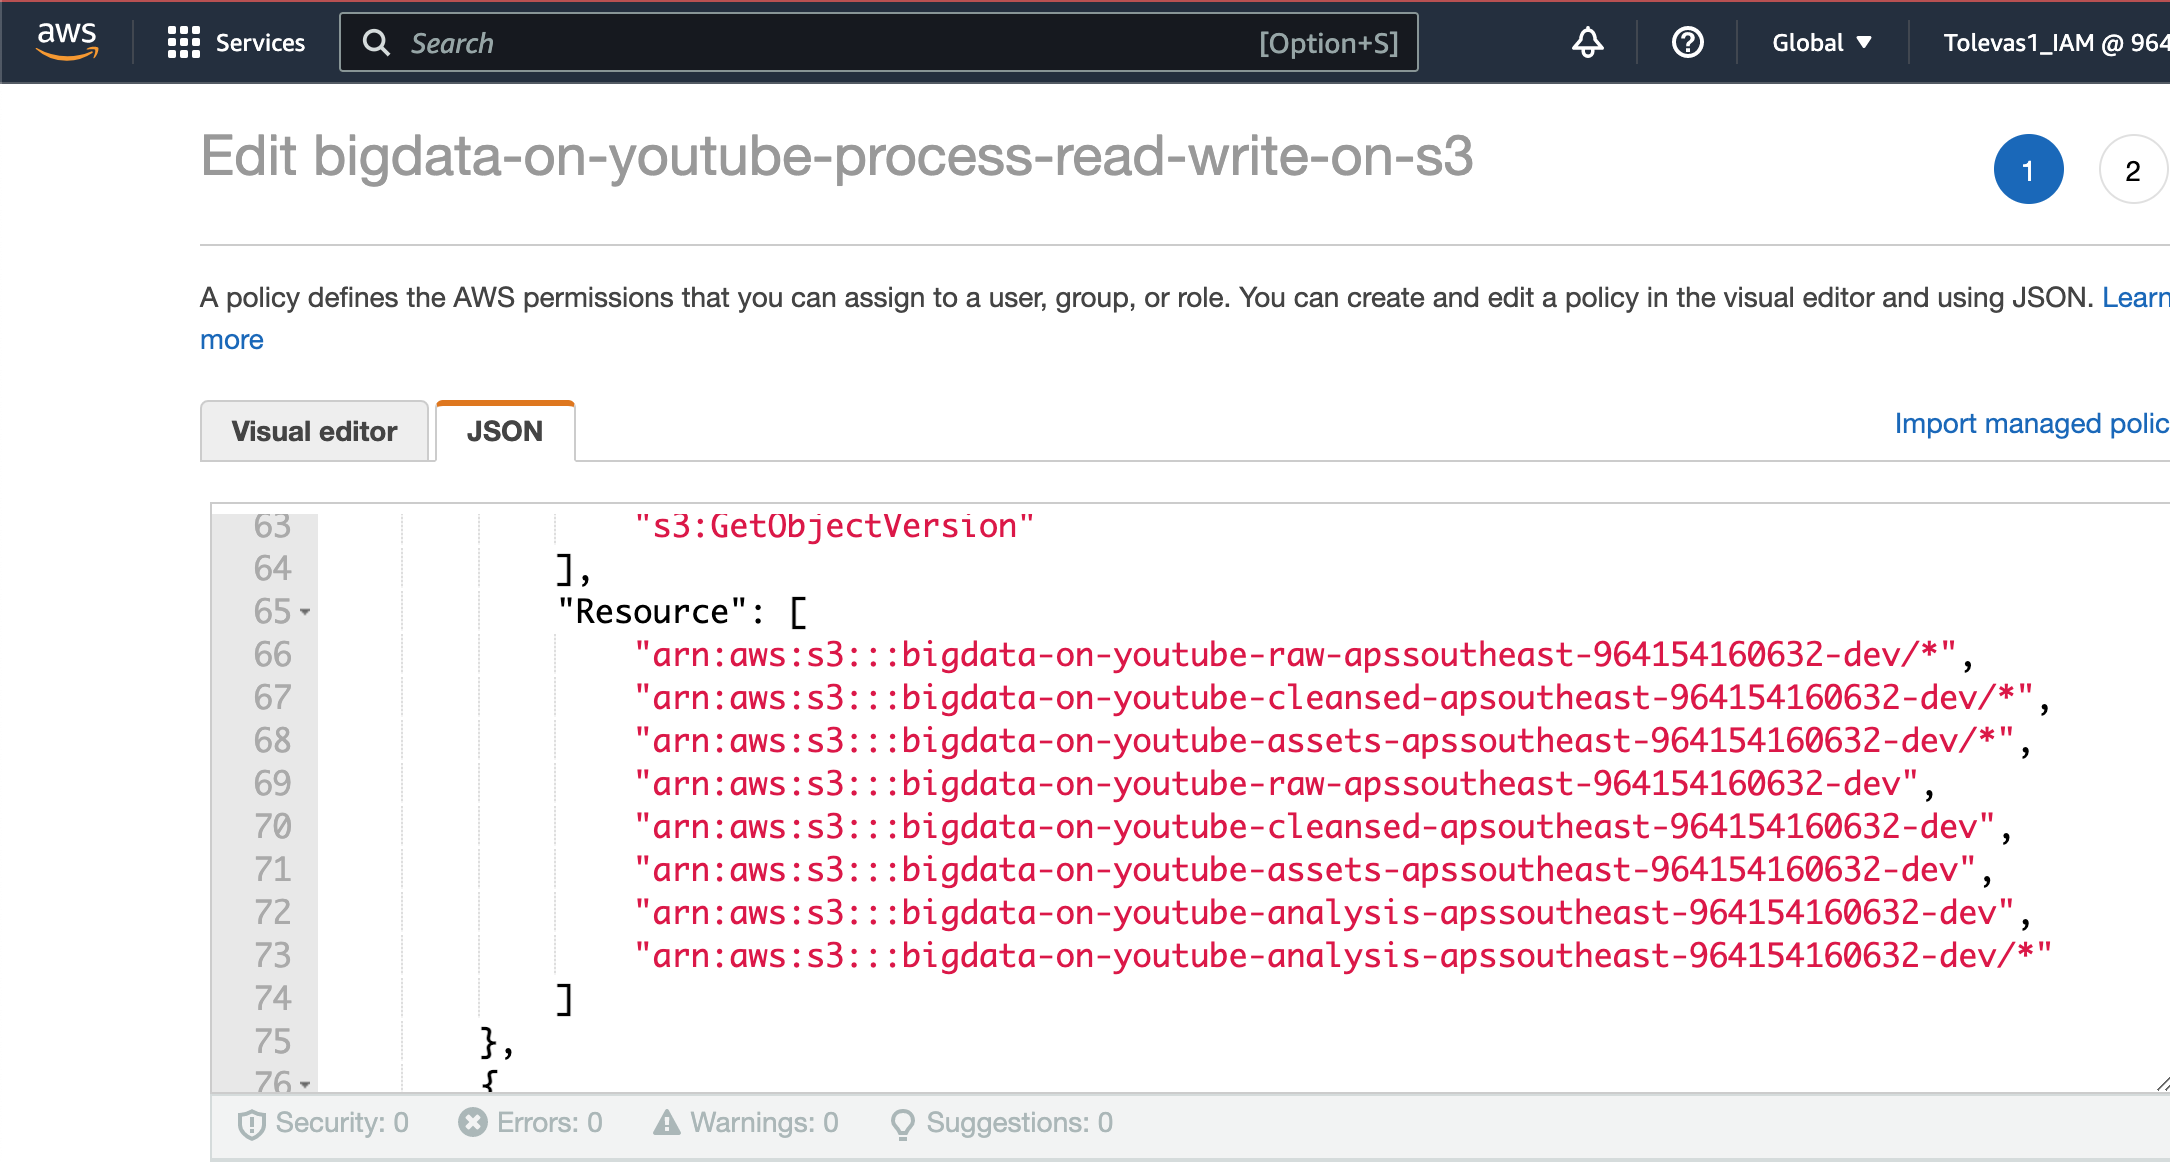
If you click edit policy you can see a more detailed list of all the permissions a policy does and doesn’t have. Example below:
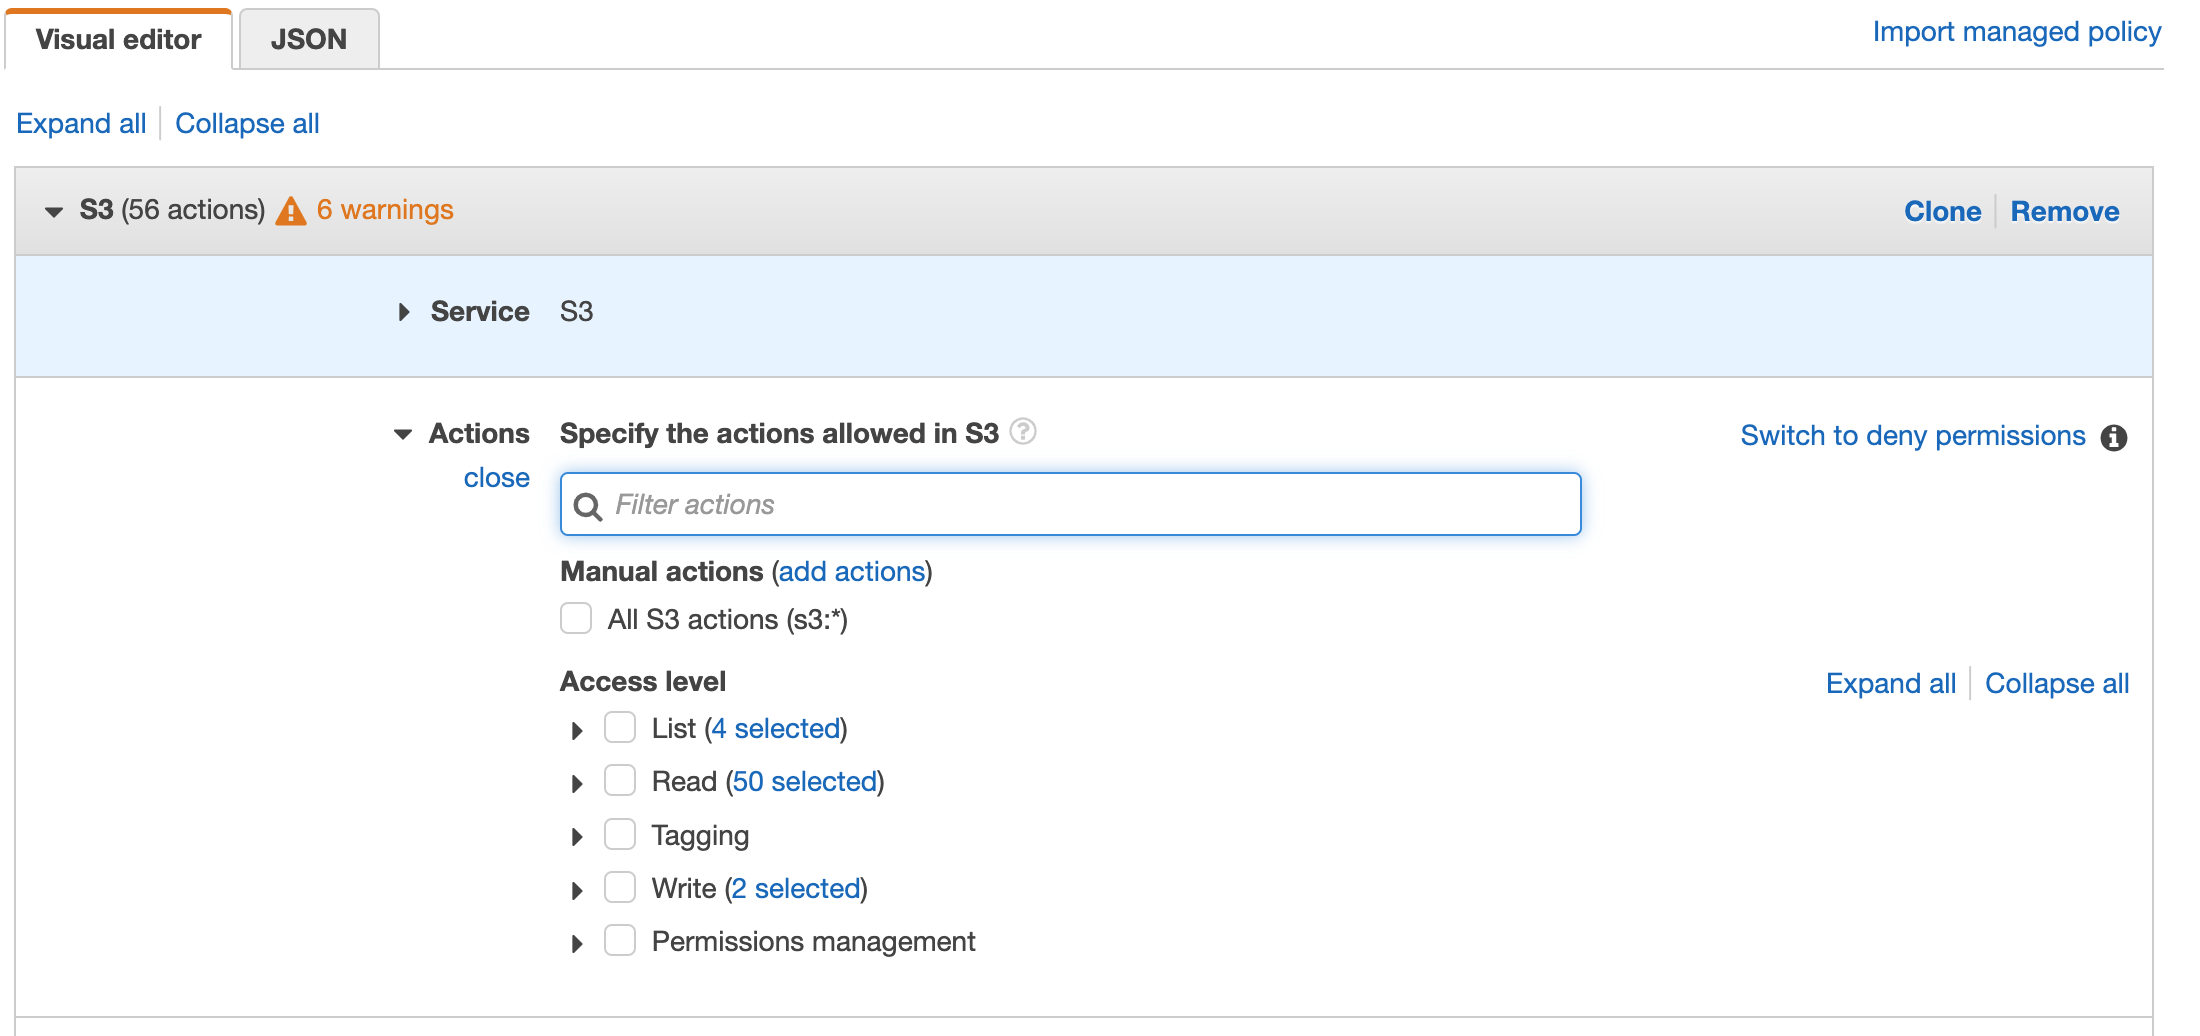

- **AWSLambdaBasicExecutionPolicy** : This policy was created to attach to the lambda function we will create later.  It simply allows the lambda function to access the necessary files in our S3 buckets so they can be converted into a more usable format. 

- **data-on-youtube-glue-service-policy1** This policy was created to give out AWS glue Job (created in a later step) access to all of the files in the raw s3 bucket in the same way as with the first policy on this list. the JSON code must be adjusted to include all s3 buckets that you need to both read and or write to. Look at the JSON code in the first policy on this list for help in updating your JSON.  the policy was also given read and write permissions as it needs to read the s3 buckets, transform the data to a new data structure, then write the new data structure into a different 'cleansed' s3 bucket. 

- **AWSQuickSightS3Policy** and **AWSQuickSightIAMPolicy** : These two policies allow AWS QuickSight to access the data in your s3 buckets for analysis and allows IAM users to visualize that data in QuickSight respectively.  

**Role List:**
While policies set the rules of what particular tools within AWS can and can’t do, roles are the accounts assigned to individuals working on or with the pipeline.  Individual roles are assigned to each of the policies created above and the user of that 'Role' account can only take the actions(read, write, tag, etc.) permitted by the policy their role account is attached to. In simpler terms, policies set the usage rules for each of the AWS tools, roles assign individual people to each of those tools and policies. Below i will list all of the roles I created for this ETL pipeline.  The purpose of each role is specified in its name
- **AWSGlueServiceRole-anatole** Allowed user 'anatole(me)' to work on AWS Glue Policy and AWS Glue tool mentioned above. Once each role is created you must click the 'Permissions' tab within that role and select any Policies you want to attach that role to. Example below (inside IAM role 'AWSGlueServiceRole-anatole')
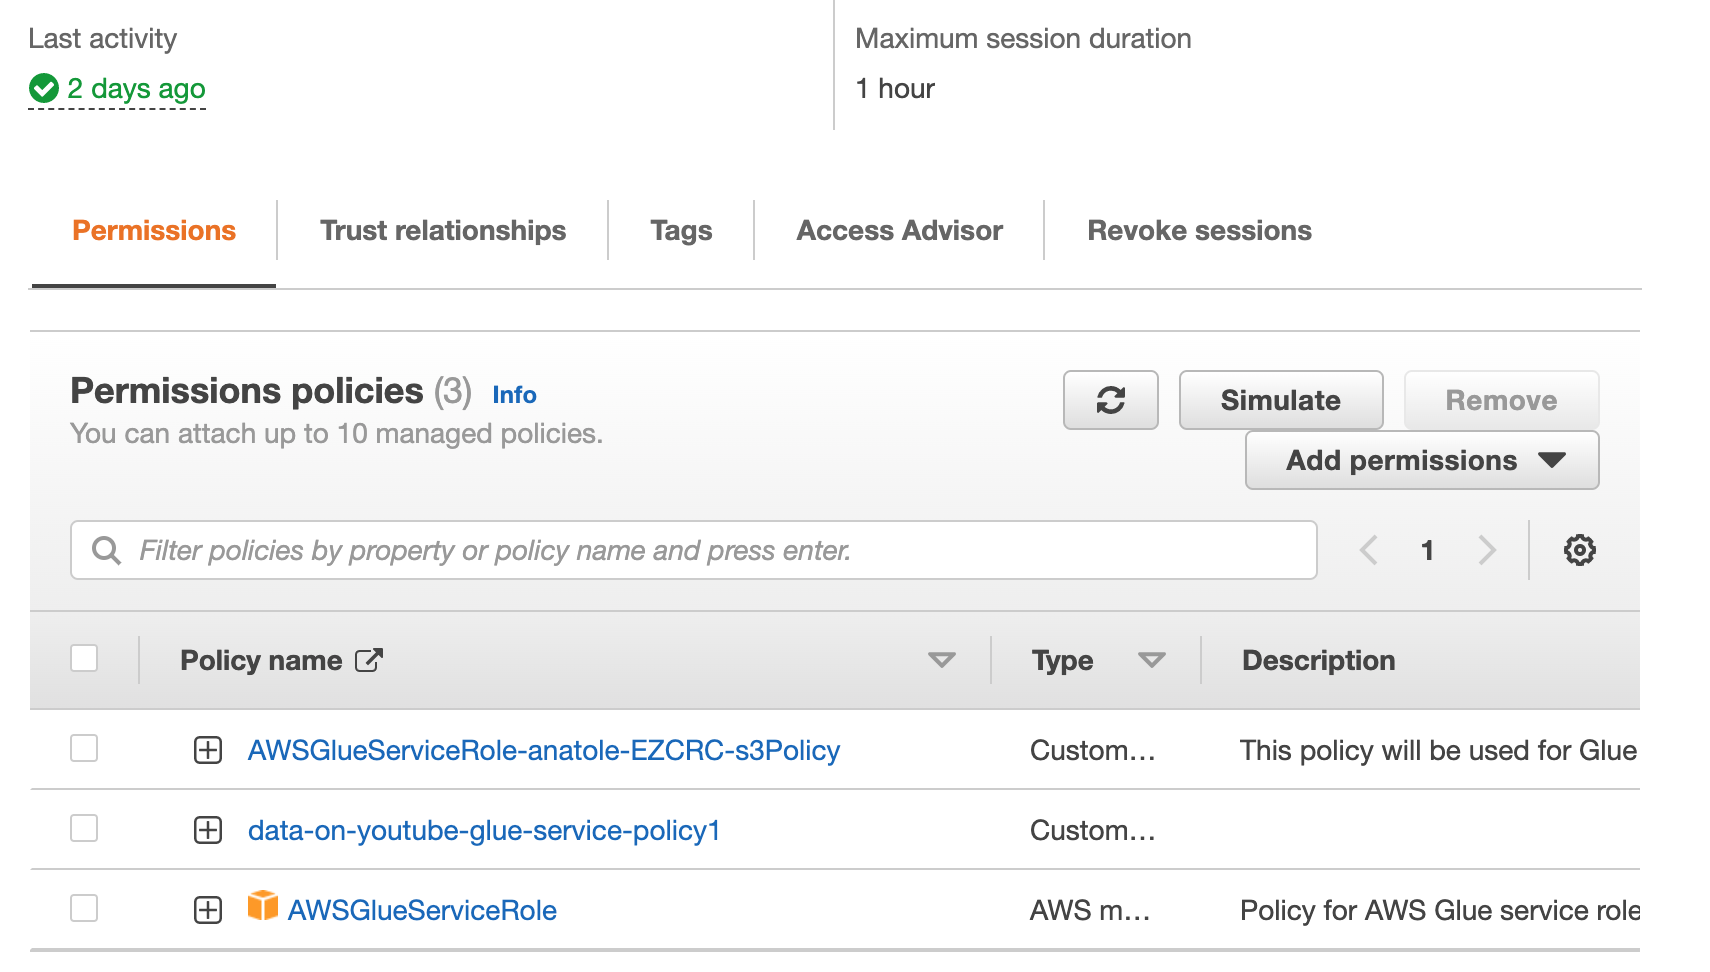
- **bigdata-on-youtube-process-jsontoparquet-lambdafun-role-n83wimgf** Allowed role owner to work on lambda function and use the Lambda policy 'AWSLambdaBasicExecutionPolicy' listed above.
- **quicksight-service-role-v0** Allowed role owner to work on AWS Quicksight and use the policies "AWSQuickSightS3Policy" and "AWSQuickSightIAMPolicy" listed above.
- **AWSServiceRoleForSupport** Allowed access to s3 buckets and any other tools not included in scope of other roles (Lambda, Quicksight, Glue)


## Part 3: Use Glue Crawler to determine Data Schema
Next well use AWS Glue's 'Crawler' feature to scrape the original files we imported to our s3 bucket.  Glue's Crawler is a program that connects to a data store (‘raw’ s3 bucket in our case), extracts metadata, and creates table definitions in the AWS Glue Data Catalog. In our case, the Glue Crawler will determine the original schema of our files (JSON and CSV) and identify the fields that we want to extract and eventually turn into columns in a parquet(data frame) data structure.  This final transformation from JSON/CSV to parquet will be completed by an AWS Lambda function or AWS Glue Job in part 4.  The crawler simply identifies structure and important fields in the JSON and CSV files so they can be converted easily later on. 
- **Create your crawler in AWS Glue** : This is very straightforward. Simply enter AWS Glue's crawler tab in the lefthand column, click create crawler, and tell the crawler what files to crawl, and tell it where to put the results of the crawl.  
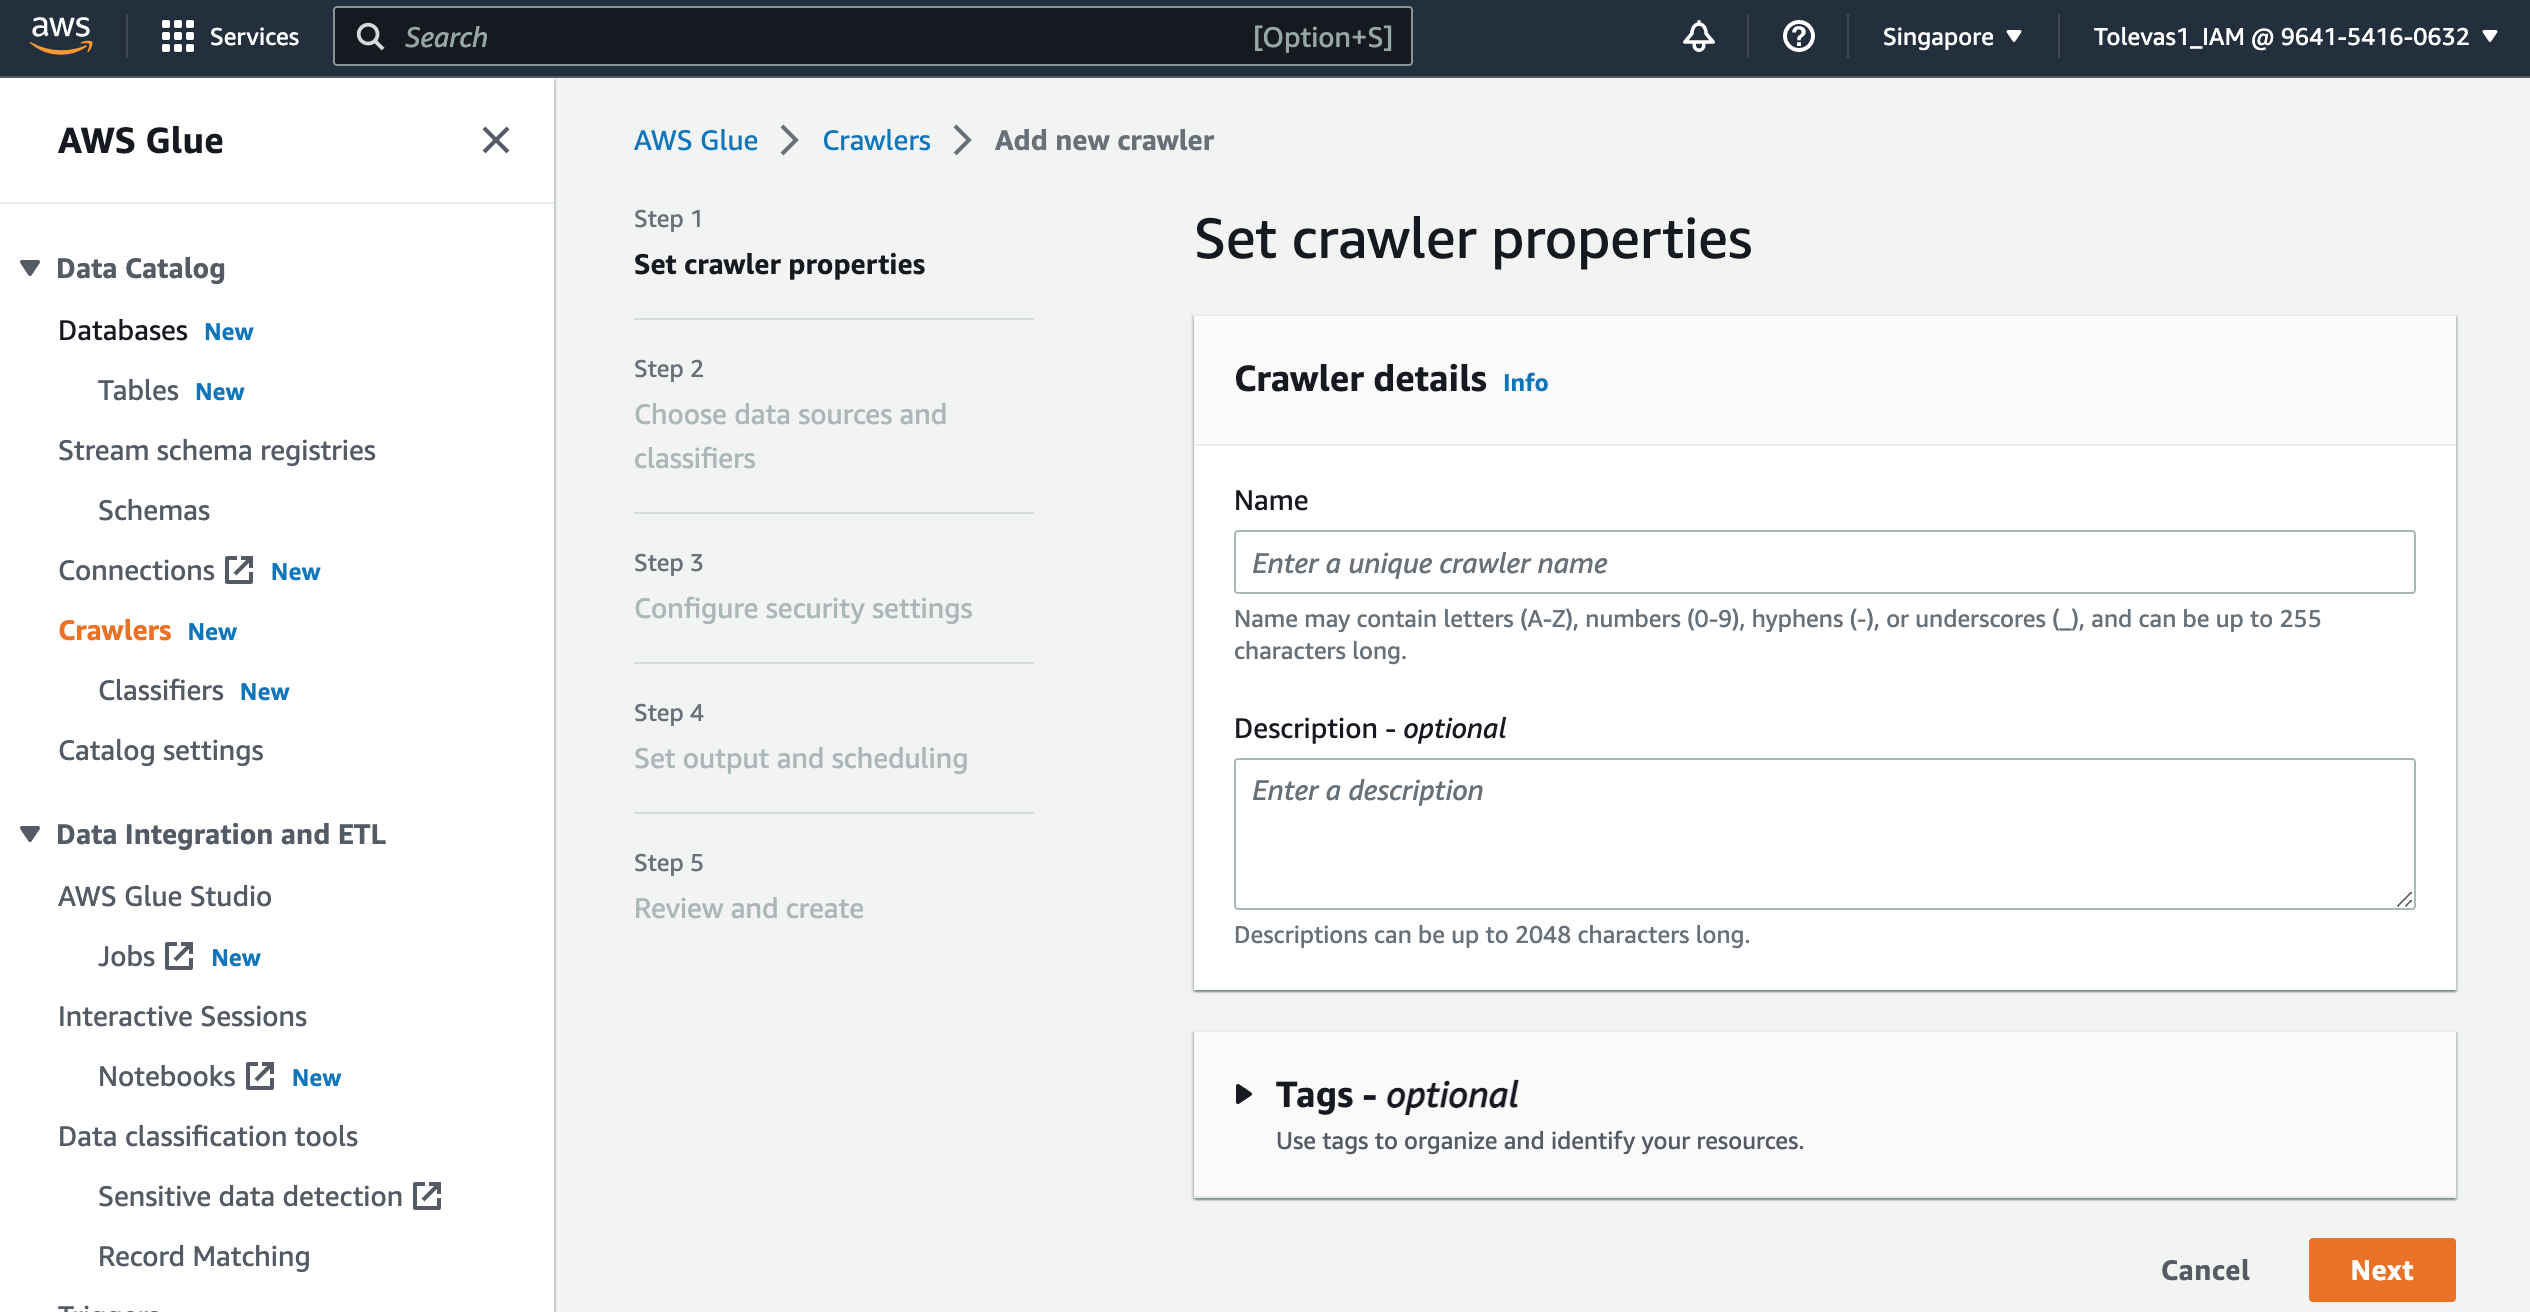
Here is the interface for creating your Glue crawler. In my case, I told the crawler to crawl the 'bigdata-on-youtube-raw-apssoutheast-964154160632-dev/youtube/raw_statistics/' (original raw JSON data) and 'bigdata-on-youtube-raw-apssoutheast-964154160632-dev/youtube/raw/' (original raw CSV data) files. I told the crawler to store the results in a AWS Glue database called 'db_youtube_raw'.  The CSV results and JSON results will be stored in separate tables within this database. To access it, you must be in the Glue page of AWS. Keep in mind that this database and its tables are separate from your s3 buckets and are native to AWS Glue.
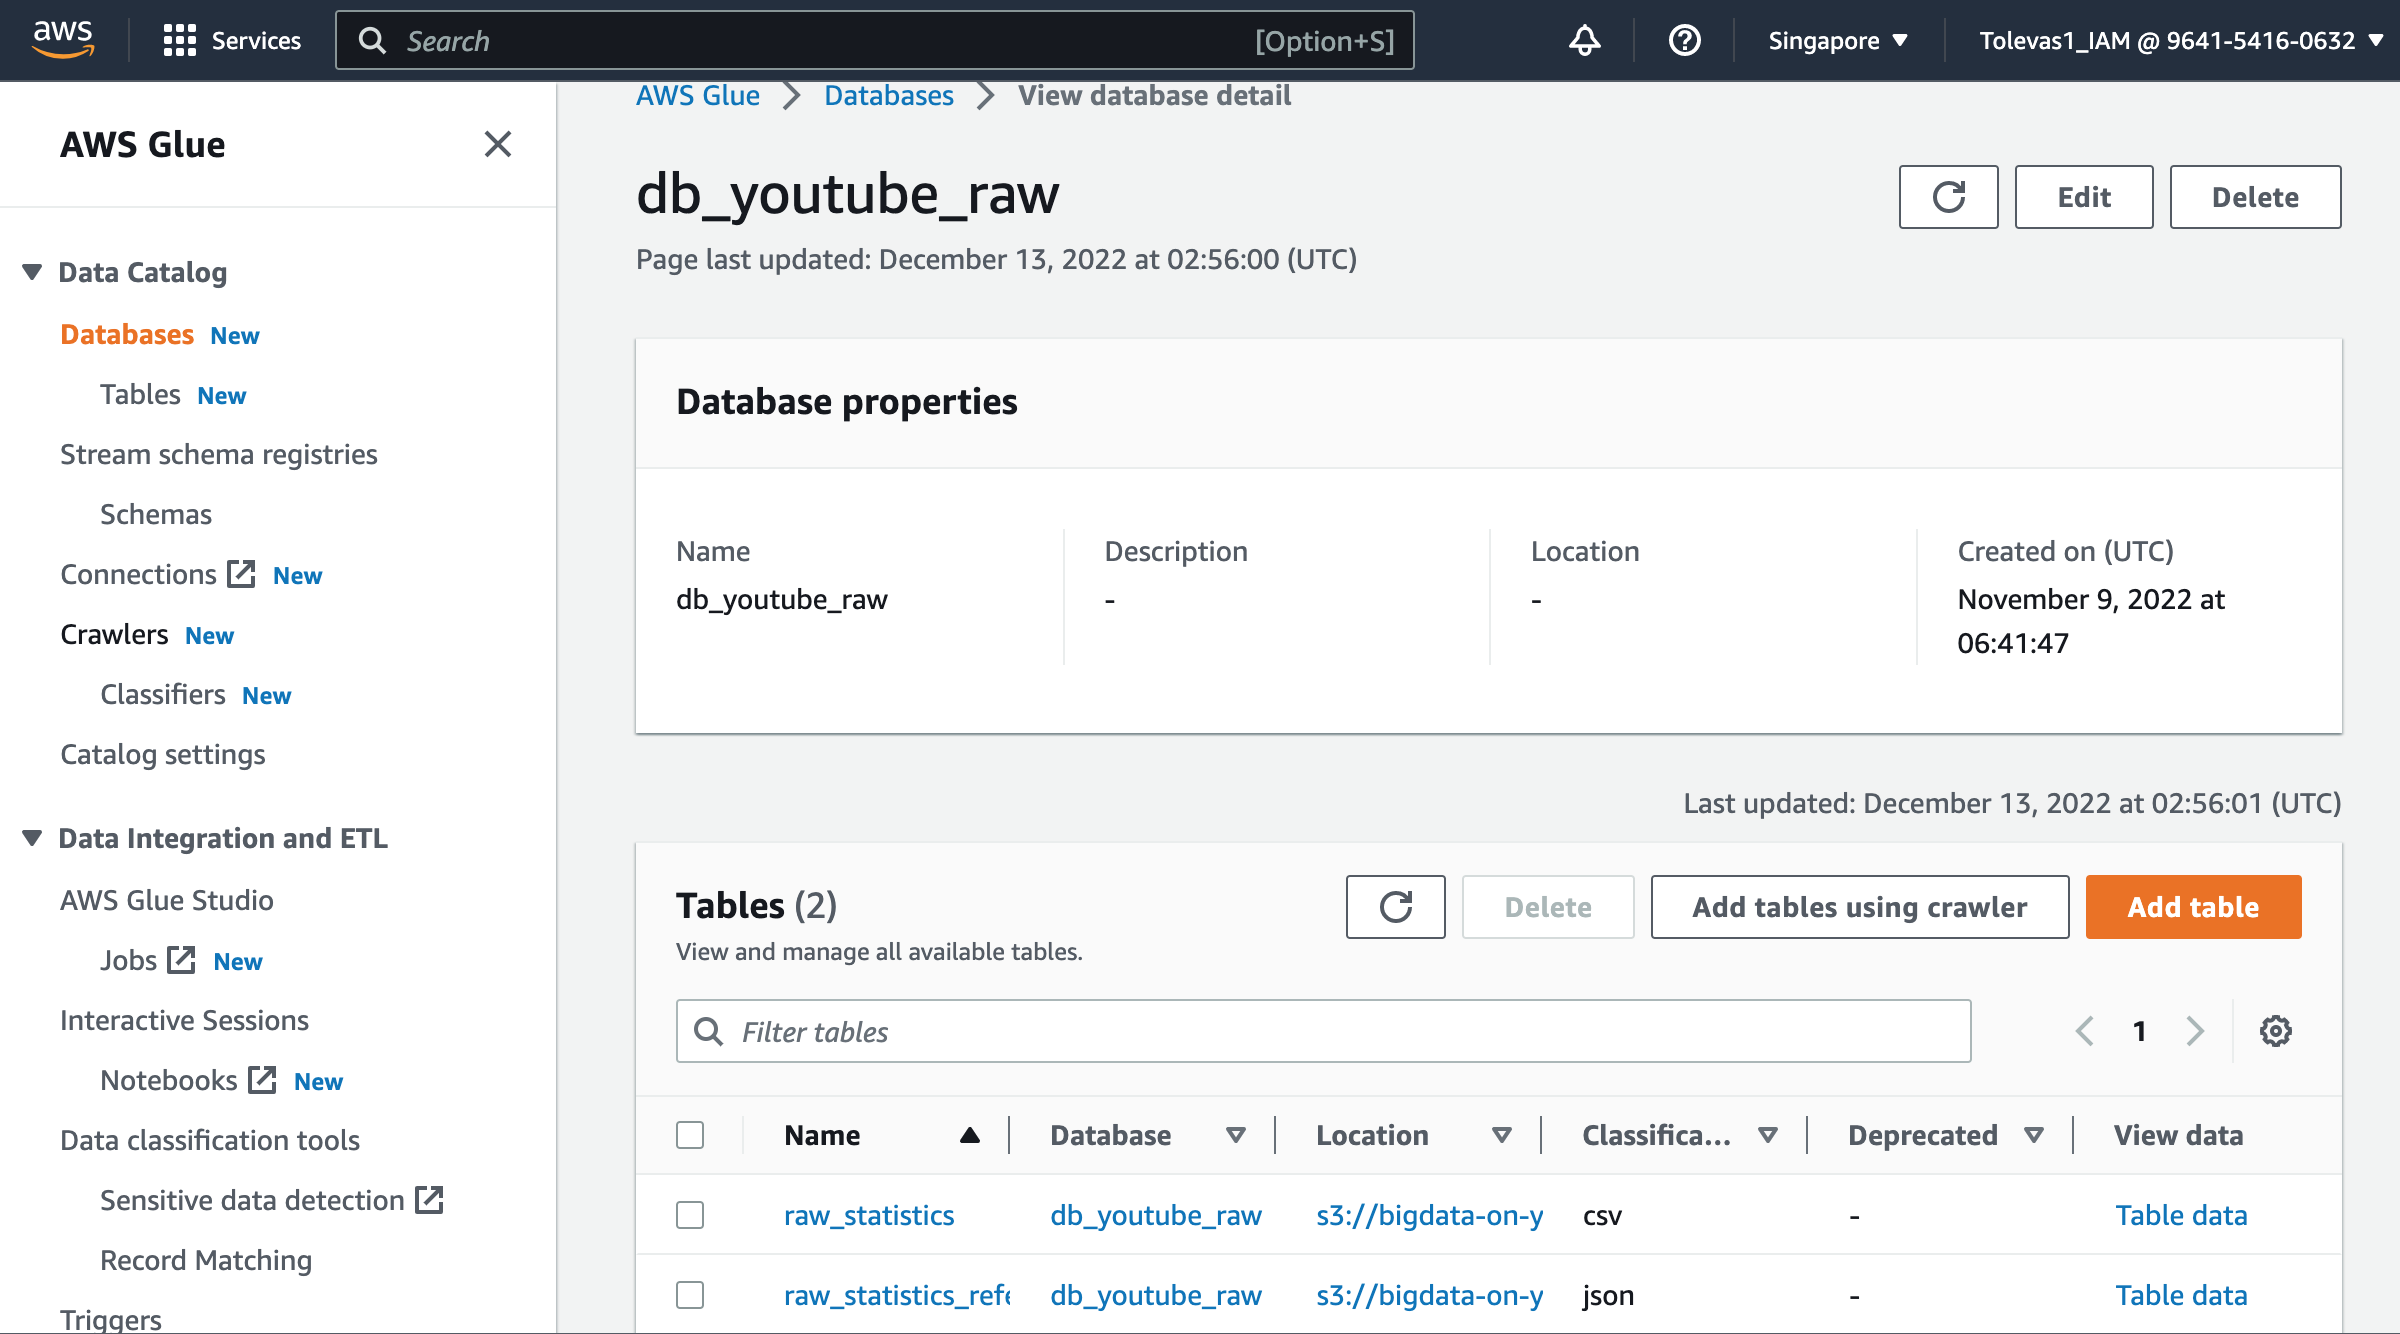
Above are the results of the crawl stored withing our Glue Database 'db_youtube_raw'
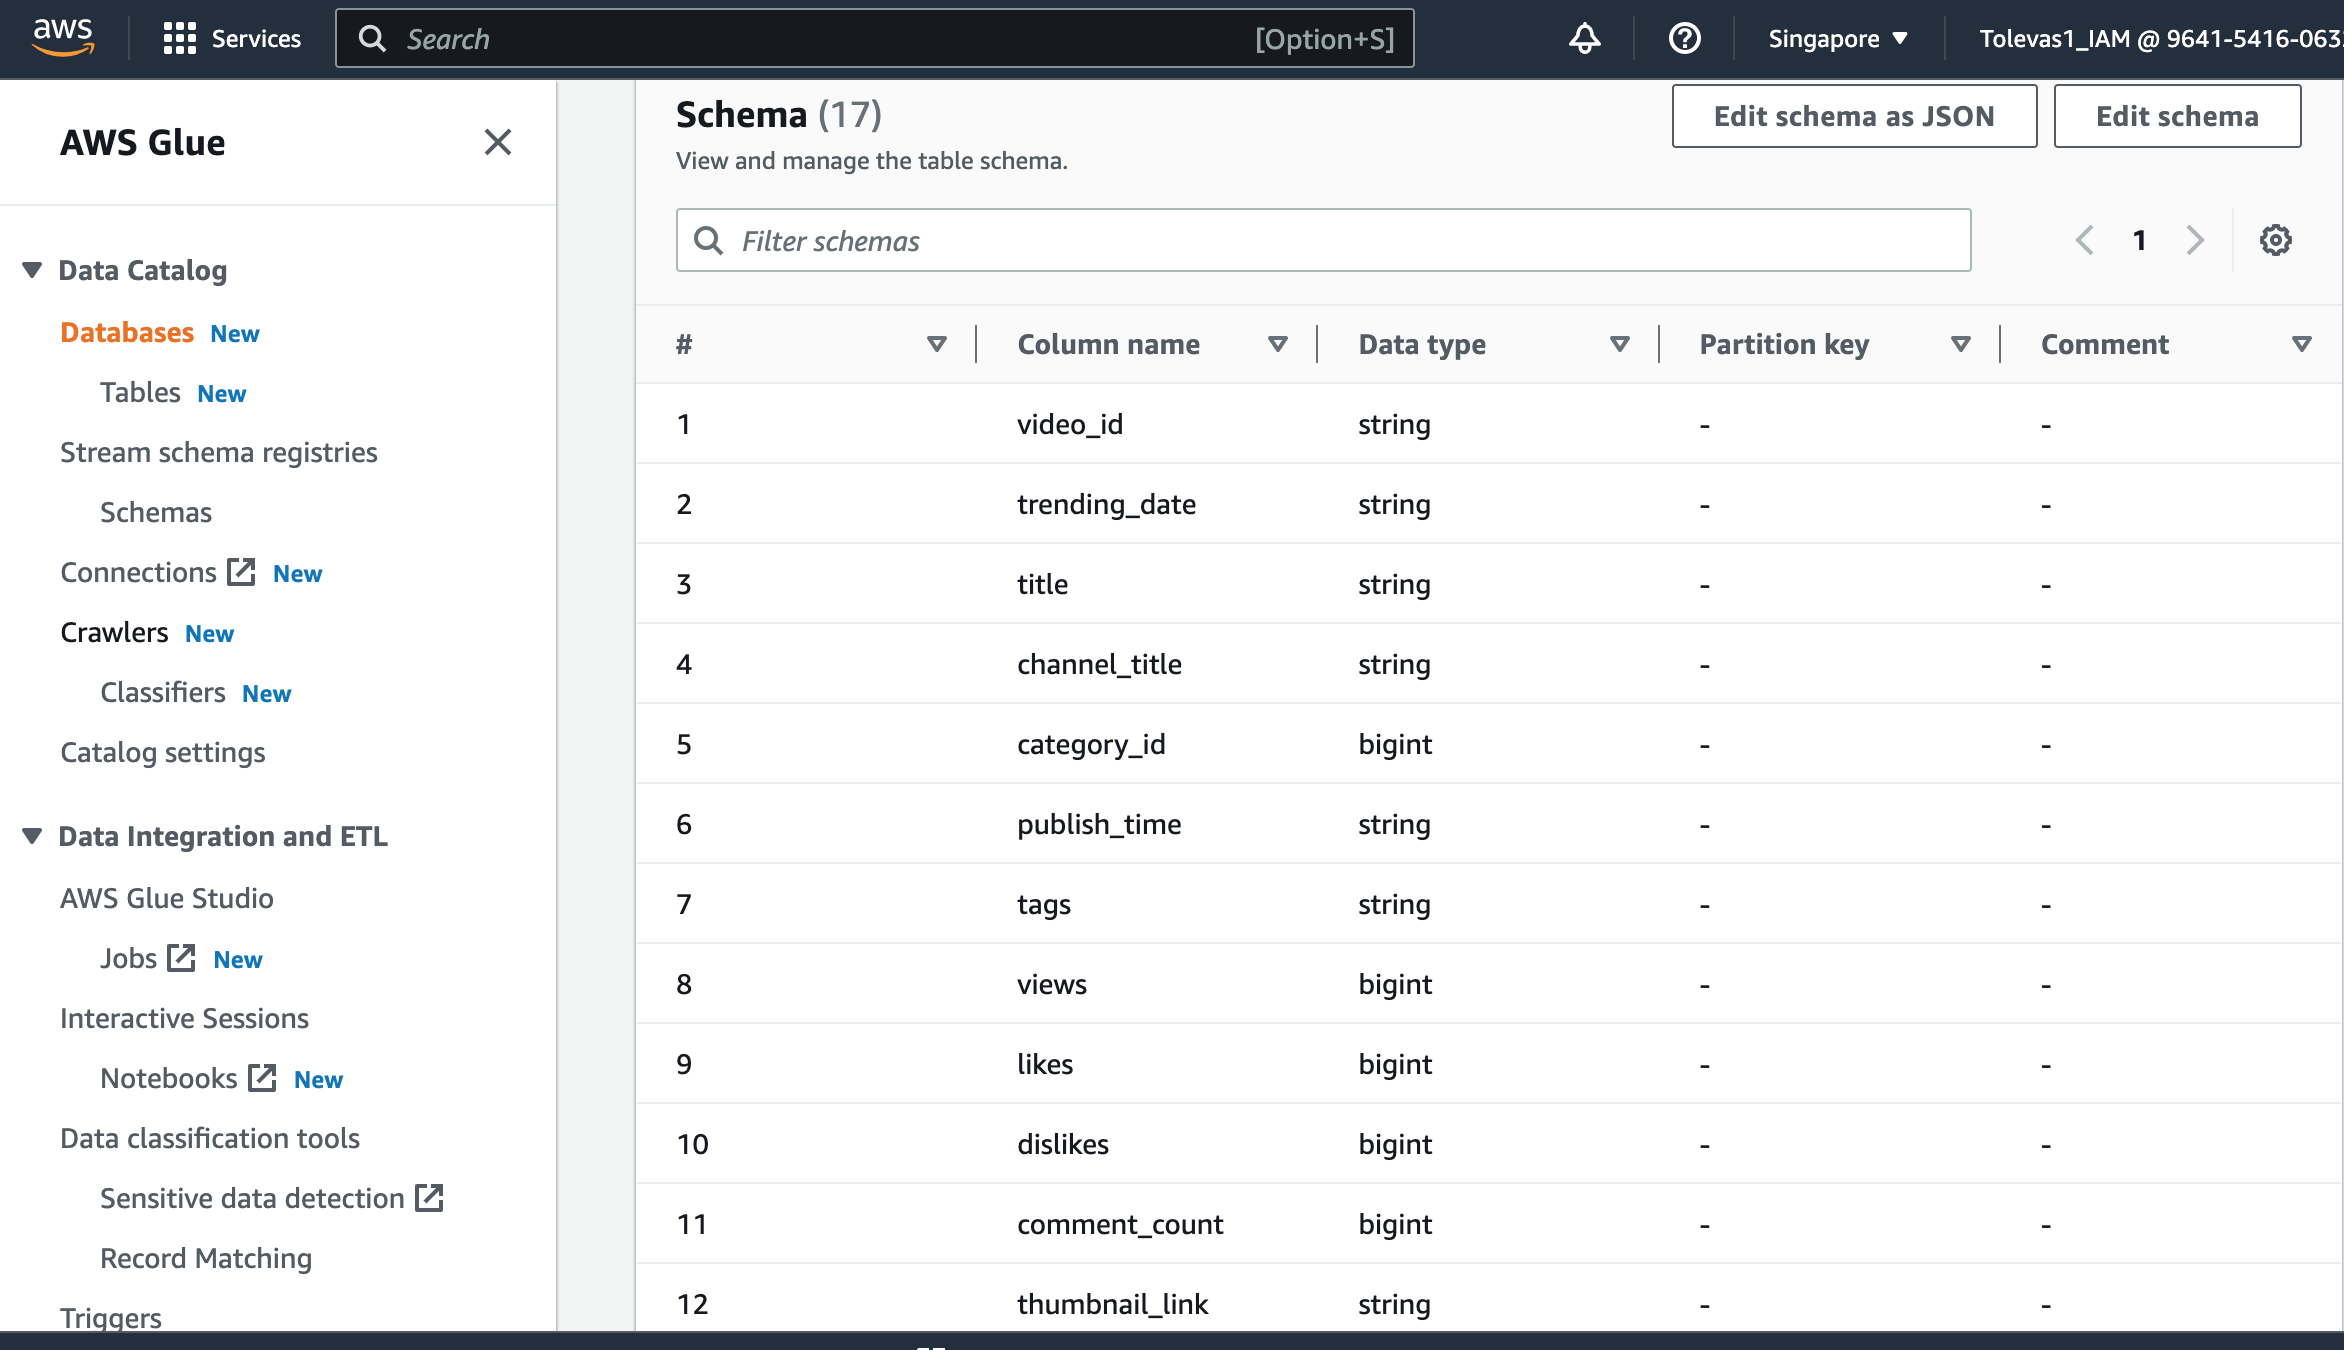
Above shows one of the tables stored within the 'db_youtube_raw' Glue Database.  This table lists all of the fields that the crawler was able to identify in our original CSV file.  This is the information that our Lambda function will need in step 4 to convert the CSV to a parquet(data frame) file that can be queried with SQL.

## Part 4: Create a Lambda function to convert JSON files to parquet files
Next we will go to AWS's Lambda page, click on the 'function' option in the left column, then click "create function".  Our function will use python code to convert the JSONs in our ''bigdata-on-youtube-raw-apssoutheast-964154160632-dev ' s3 bucket into Parquet files that will be stored in a separate s3 bucket named 'bigdata-on-youtube-cleansed-apsoutheast-964154160632-dev' 
- You may wonder why we need to convert the JSON to a Parquet file if the Glue crawler already found all the fields in the raw JSON file. The reason for this is that although the crawler identified the fields, it did not create a new file with that field information that can be queried with SQL.  We used to crawler to infer the schema of the JSON data which will help us write our lambda function code to fully convert that JSON into a new parquet file that CAN be queried by SQL and used by Amazon QuickSight for our final visualization and analysis. 
The chart below helps visualize all the steps we are using to make our original JSON data in a queryable Parquet file. 
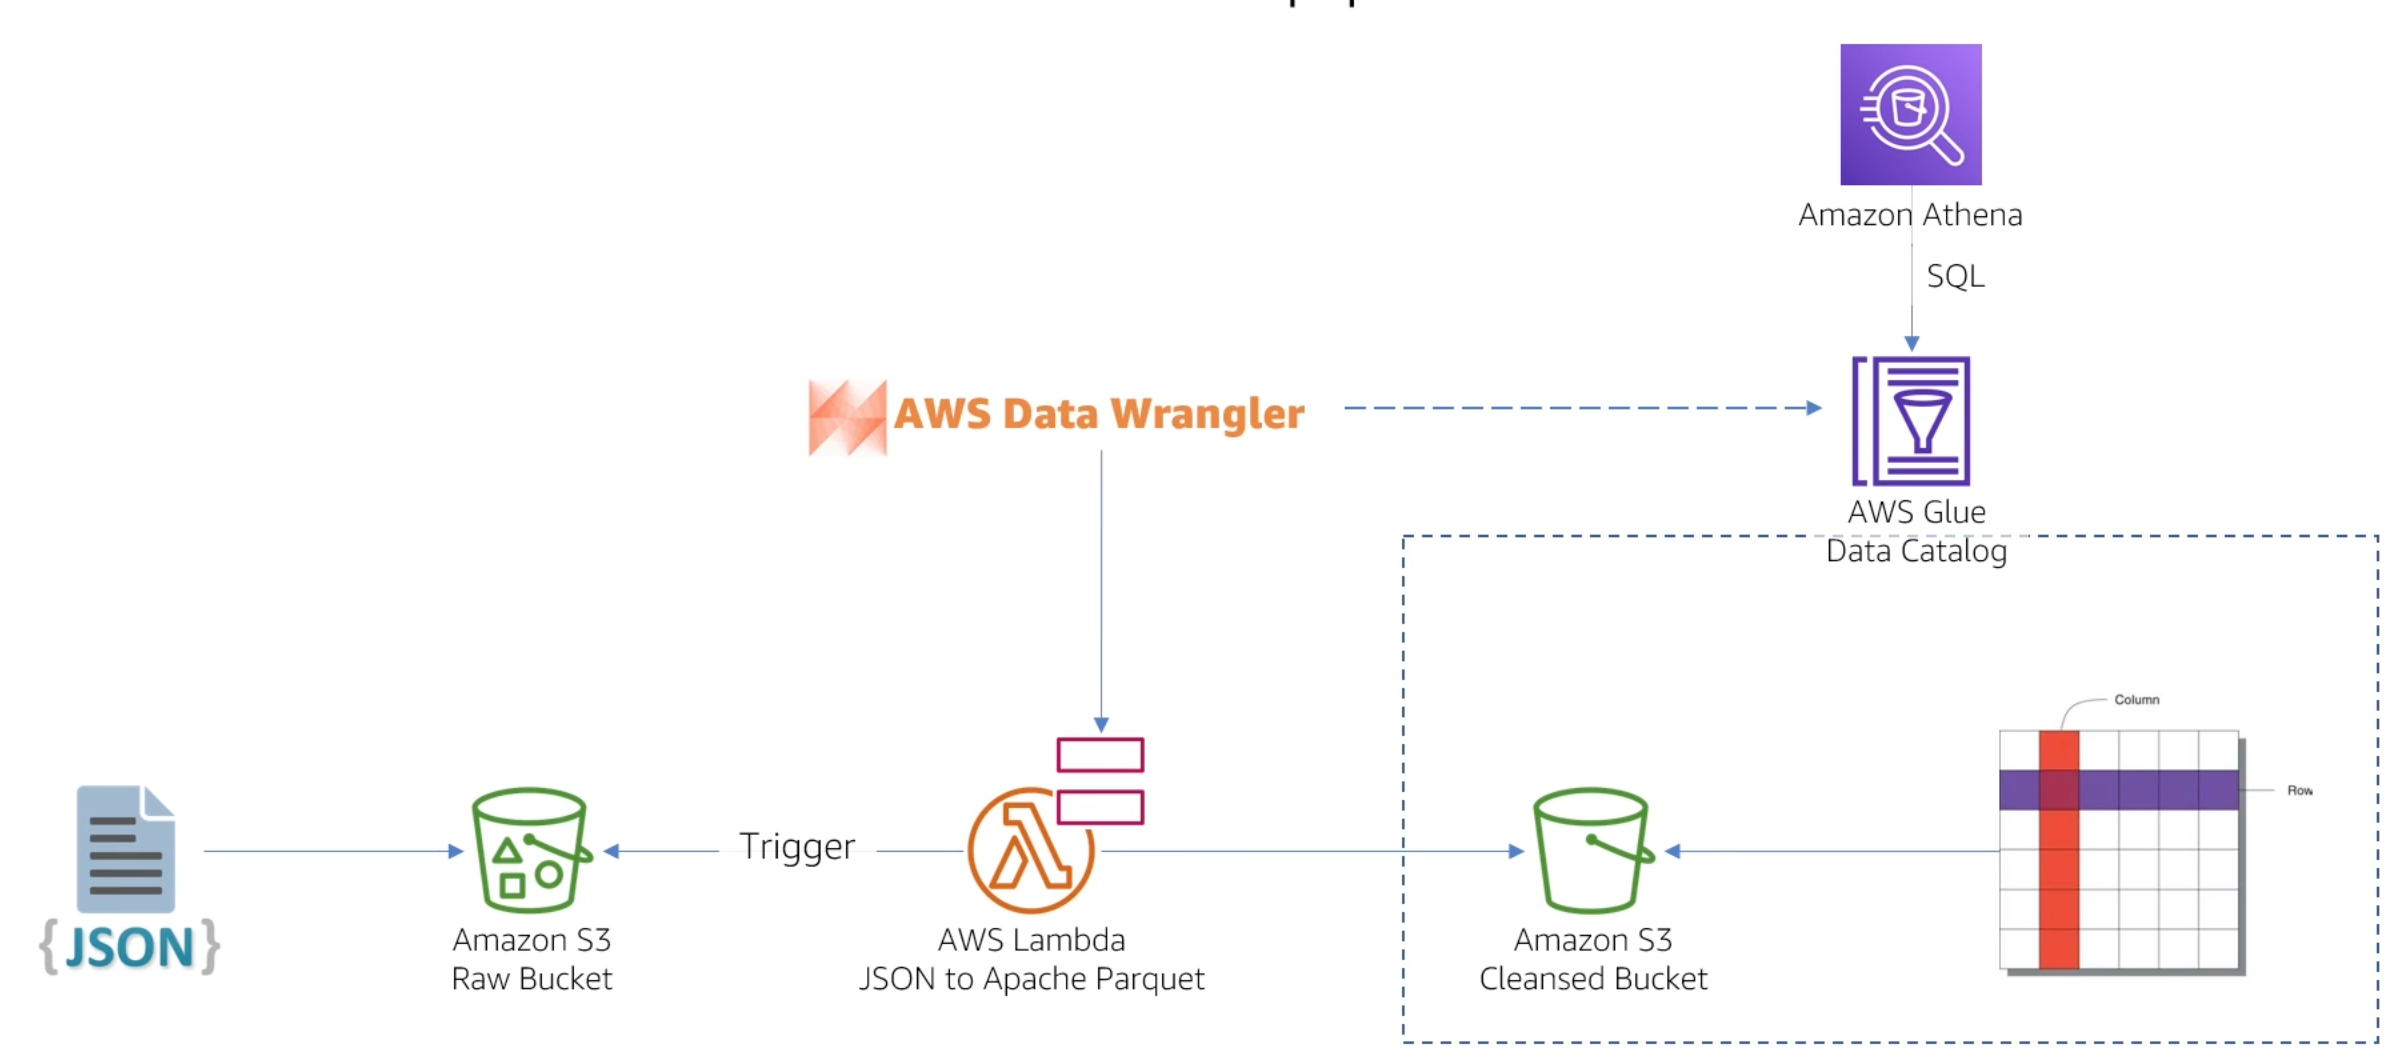


- **Step 1:** There are several ways to create a Lambda function.  You can write your function code from scratch (in several available programming languages) but AWS also has a feature where you can use their code blueprints and tweak them based on your needs.  The options will appear as follows,
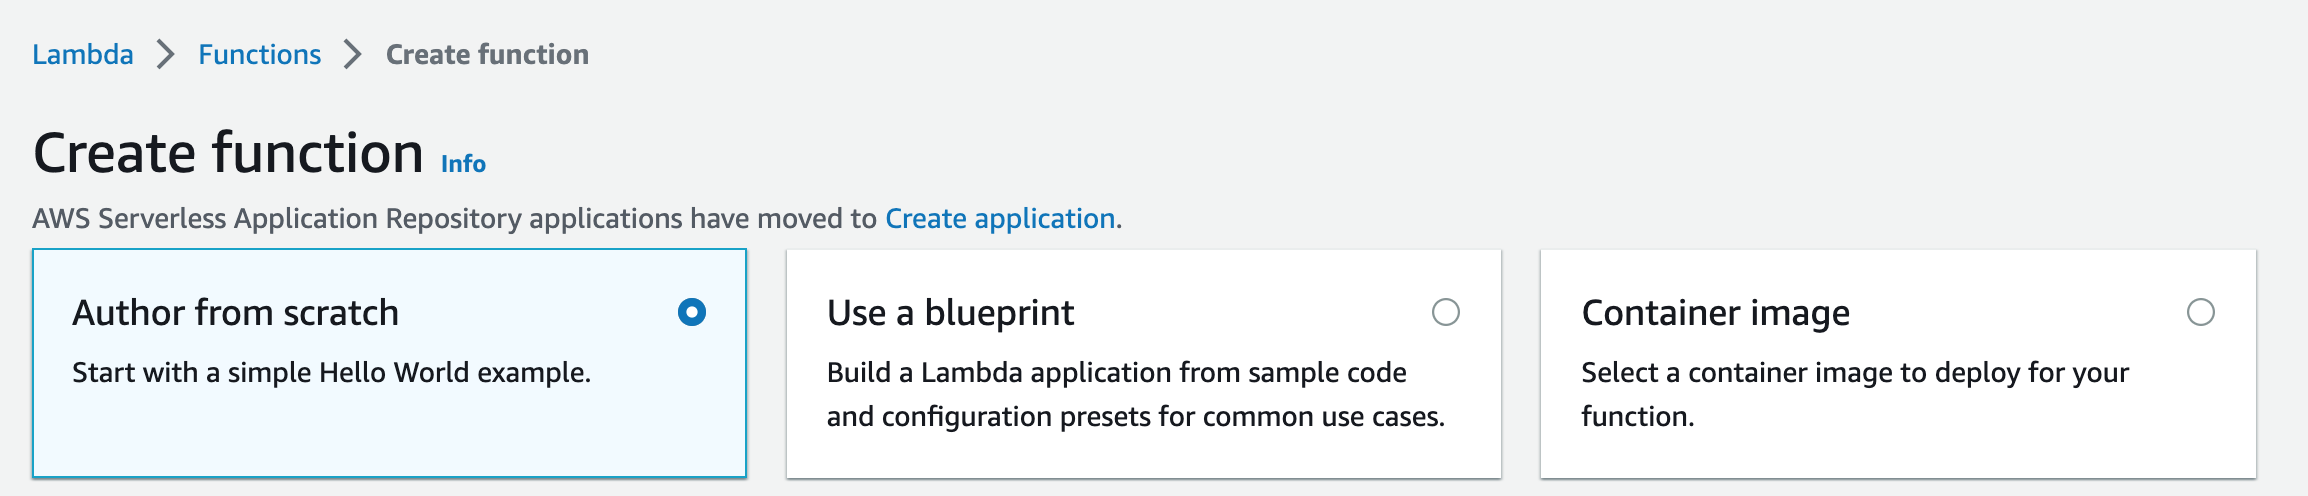
    - We will use Python to write our Lambda function from scratch. The code used for our data transformation can be seen below. It first uses the tables in our AWS Glue database to find out what information to pull from the raw JSON, then it pulls that data and converts the JSON format to a data frame, then finally outputs that JSON as a parquet file.  Be aware that your code will need to be slightly different than this based on the file types you begin with and where you'd like to drop your new converted files. 
    - If you need help writing your Lambda function, OpenAI’s ChatGPT bot is incredible at writing these types of functions for you or helping you trouble shoot errors in your code.  If you are not yet familiar with Chat GPT then you should definitely check it out.  Its undoubtedly a life changing technology for developers and will save you literally thousands of hours over the lifetime of your career!
        - Chat GPT: https://openai.com/blog/chatgpt/ 


In [1]:
import awswrangler as wr
import pandas as pd
import urllib.parse
import os

# Temporary hard-coded AWS Settings; i.e. to be set as OS variable in Lambda
print('blahblah', os.environ['AWS_REGION'])
os_input_s3_cleansed_layer = os.environ['s3_cleansed_layer']
os_input_glue_catalog_db_name = os.environ['glue_catalog_db_name']
os_input_glue_catalog_table_name = os.environ['glue_catalog_table_name']
os_input_write_data_operation = os.environ['write_data_operation']


def lambda_handler(event, context):
    print(event)
    # Get the object from the event and show its content type
    bucket = event['Records'][0]['s3']['bucket']['name']
    key = urllib.parse.unquote_plus(event['Records'][0]['s3']['object']['key'], encoding='utf-8')
    try:

        # Creating DF from content
        print('s3://{}/{}'.format(bucket, key))
        df_raw = wr.s3.read_json('s3://{}/{}'.format(bucket, key))

        # Extract required columns:
        df_step_1 = pd.json_normalize(df_raw['items'])

        # Write to S3
        wr_response = wr.s3.to_parquet(
            df=df_step_1,
            path=os_input_s3_cleansed_layer,
            dataset=True,
            database=os_input_glue_catalog_db_name,
            table=os_input_glue_catalog_table_name,
            mode=os_input_write_data_operation
        )

        return wr_response
    except Exception as e:
        print(e)
        print('Error getting object {} from bucket {}. Make sure they exist and your bucket is in the same region as this function.'.format(key, bucket))
        raise e

ModuleNotFoundError: No module named 'awswrangler'

**Don’t worry about the error message! This won't show up when running the code in AWS Lambda as  awswrangler package is included in Lambda automatically.**
- **Step 2:** Now that your Parquet files have been created and placed in your 'bigdata-on-youtube-cleansed-apsoutheast-964154160632-dev' bucket, you can use AWS Glue Crawler to crawl the 'cleansed' bucket and add tables with the cleansed data to your AWS Glue databases. The steps for configuring this crawler as the same as creating our previous crawler, simply make sure you’re now crawling the 'cleansed' bucket as opposed to the 'raw' bucket.
    
- **Step 3:** Once this step is complete, your cleansed Parquet data tables should be present in the 'tables' tab of your AWS Glue page.  Now you are able to use AWS Athena (SQL) to query your newly created parquet files.  Make sure to write and test a simple query before moving forward to make sure your Lambda function/crawl worked properly.  AWS lambda has the same layout as most SQL querying platforms but if you are unfamiliar with SQL, make sure to take a moment to read about the basics of writing SQL queries before moving on. 
    - Below is the simple query I used to test that my lambda function and Glue crawler performed their jobs correctly
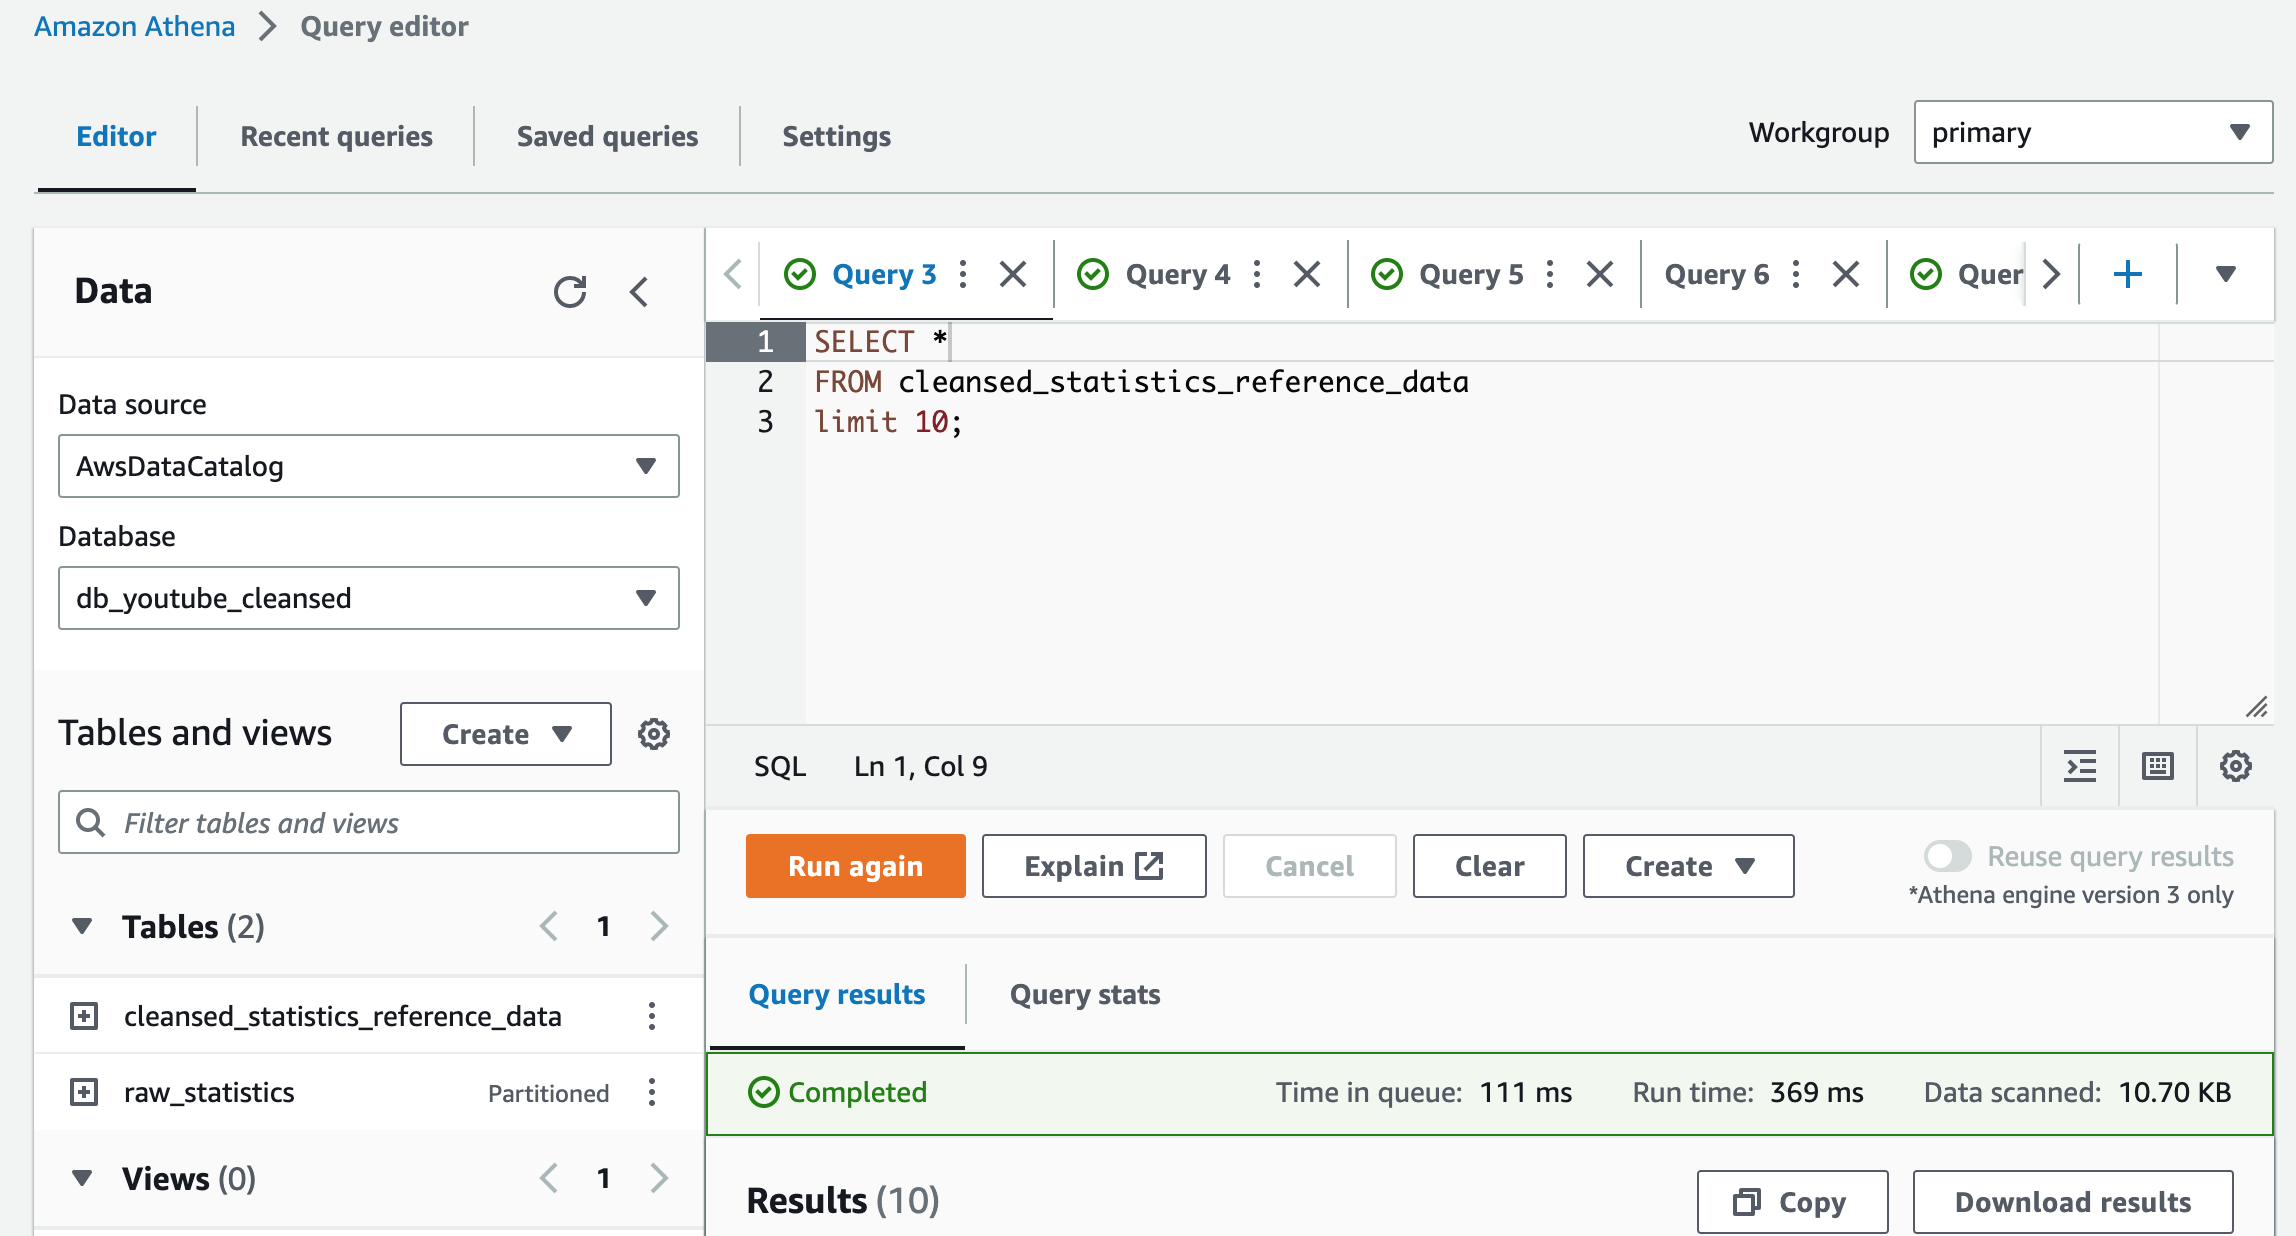
The results of this query can be seen below
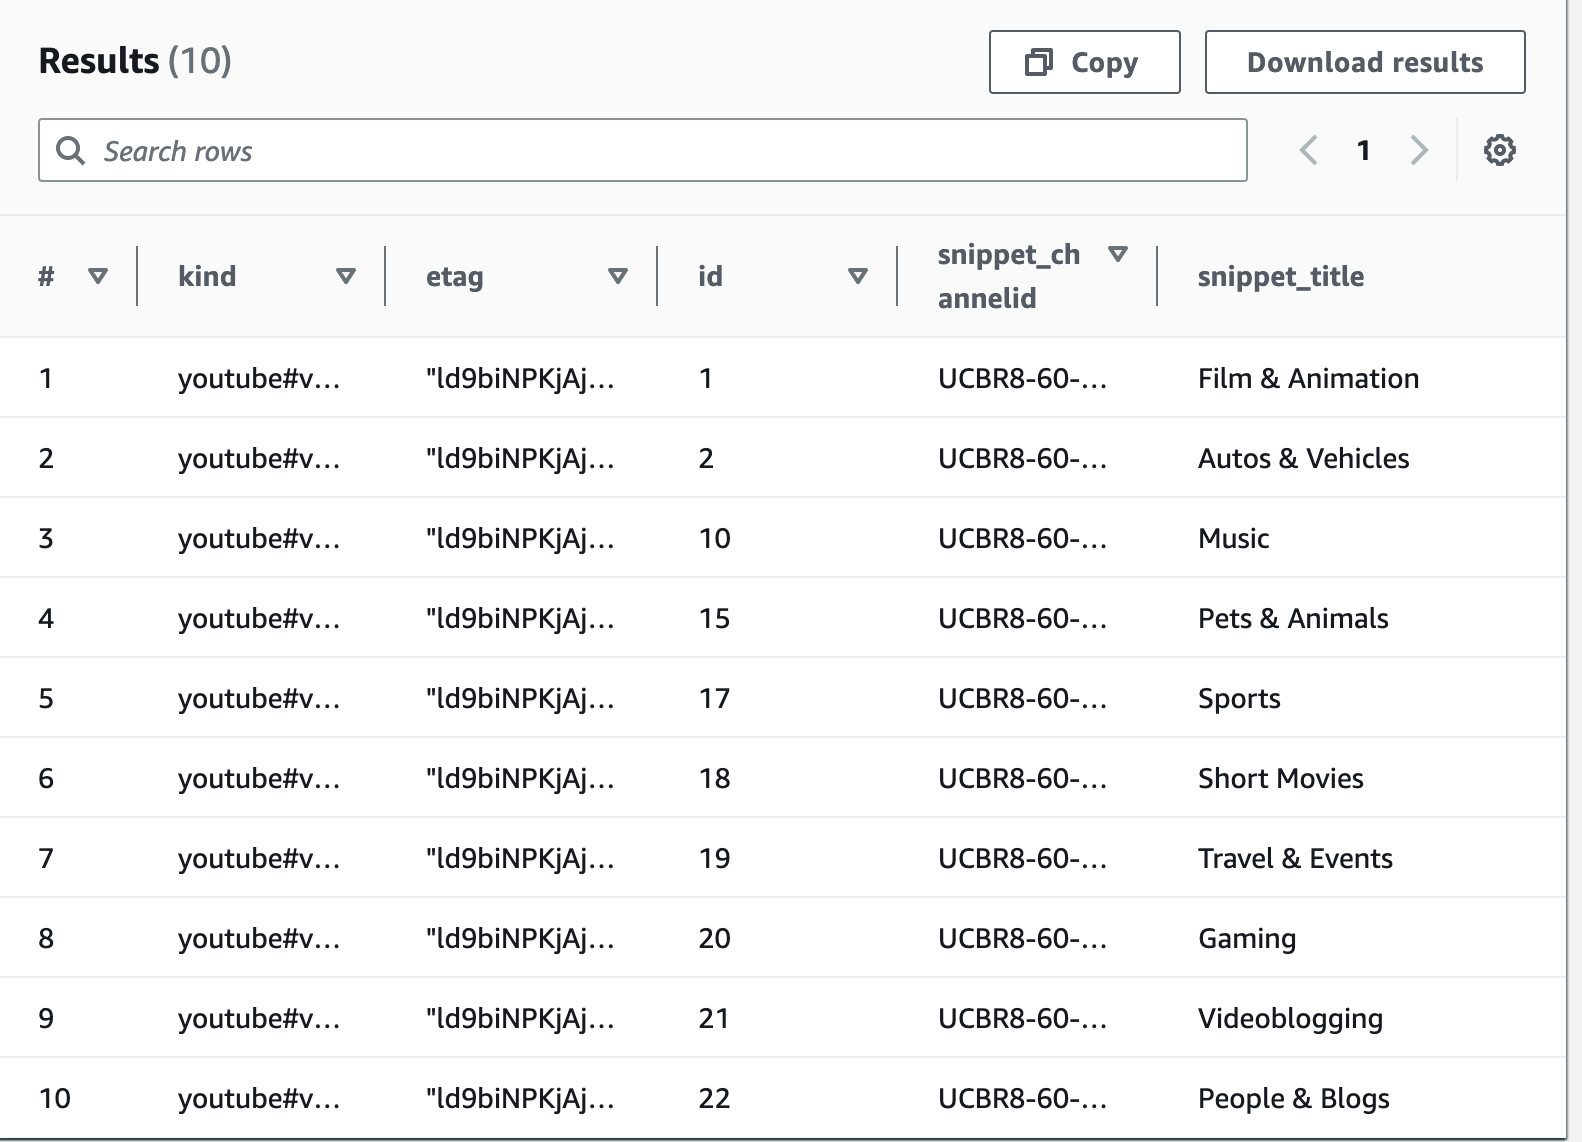

## Part 5: Create a AWS Glue Spark Job converting CSV files to Apache Parquet files.
While we've already converted our JSON files to Parquet files, crawled them, added the data to our Glue databases and tables, and tested querying them. We now need to do the same for our CSV files.  While we could use Lambda to complete this task, like we did with the JSON files, instead we will used AWS Glue Jobs. Glue Jobs, like Lambda, allows us to write code that manipulates our data directly in AWS.  The difference between Lambda and Glue Jobs is that Glue jobs can be easily automated and programmed to perform a given task any time a certain event occurs.  For example, we will later configure out Glue Job to execute any time a new file is added to our 'raw' s3 bucket.  This means that AWS will automatically convert that raw data (CSV) to a parquet file.  While this same task can be completed with Lambda, it is much easier to configure in AWS Glue Jobs.  **I decided to use both in this tutorial so you are familiar with several ways of accomplishing your data transformations.**

- **Step 1: Create a Glue Job** Click into the Jobs tab on the left hand column of your AWS Glue console. You should see the options in the image below. Here you must select the data 'source' containing the raw data you want to transform (CSV files in our case), as well as the 'target' where you want your transformed Parquet files to be stored (‘cleansed’ s3 bucket in our case).  Make sure to name your Job in a way that indicates its function. I named mine 'bigdata-on-youtube-spark-convert-csv-to-parquet2
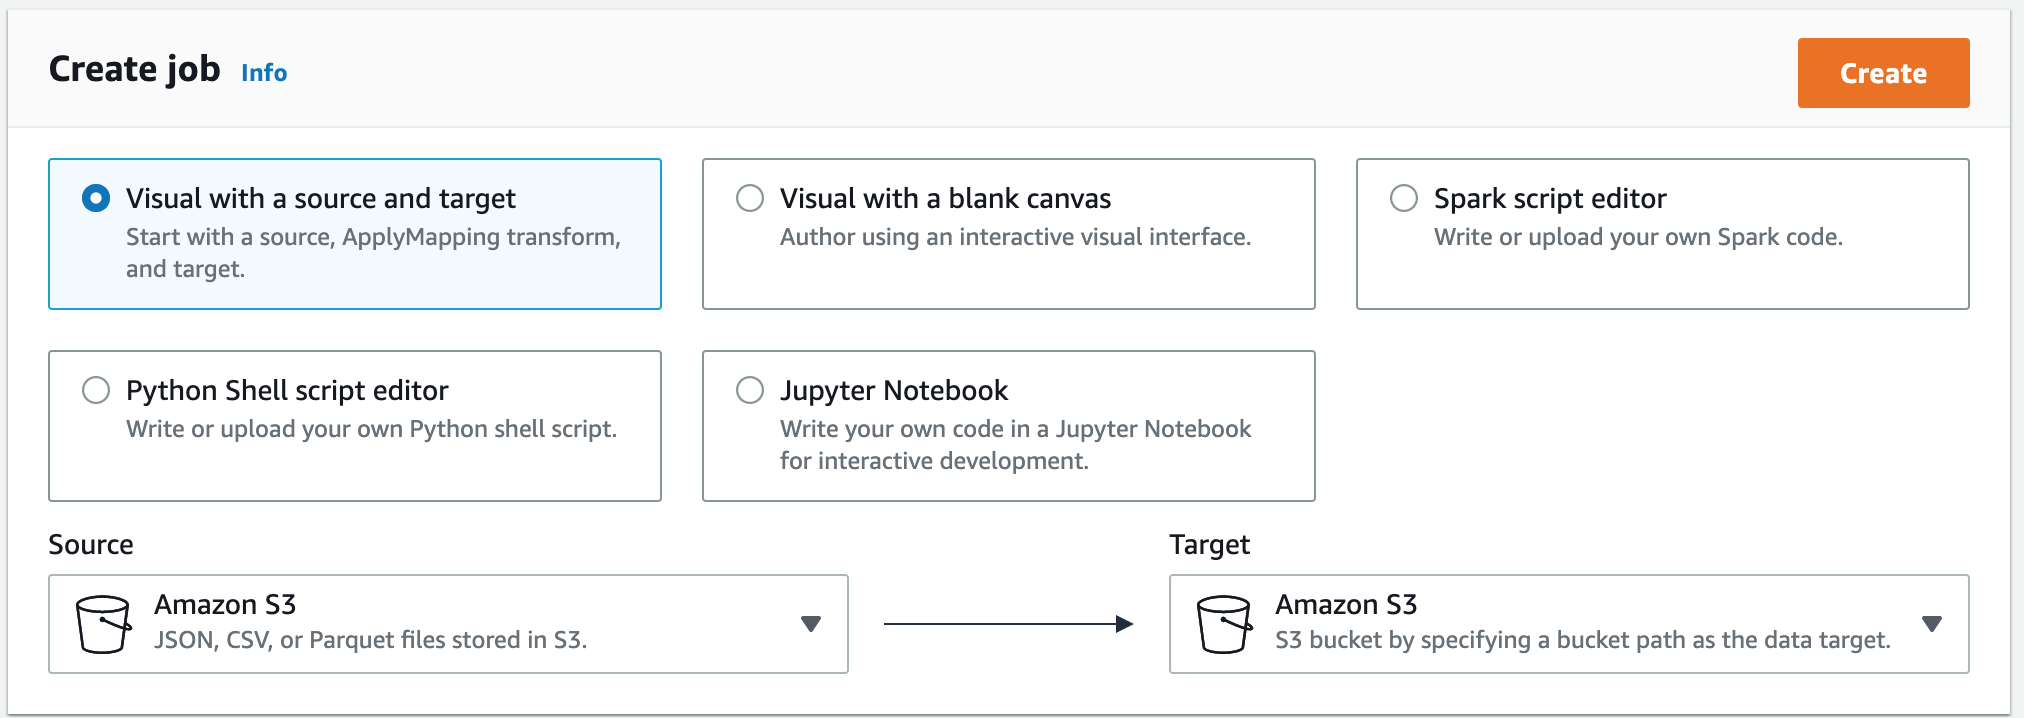
- **Step 2: ** Once you've selected your data 'source' and your 'target' you will be taken to the page shown below. Here you can adjust what sort of task is being done inside your Glue Job.  In our ETL we will be using our s3 bucket with 'raw' data as a source and our s3 bucket with 'cleansed' in the title as a target. 
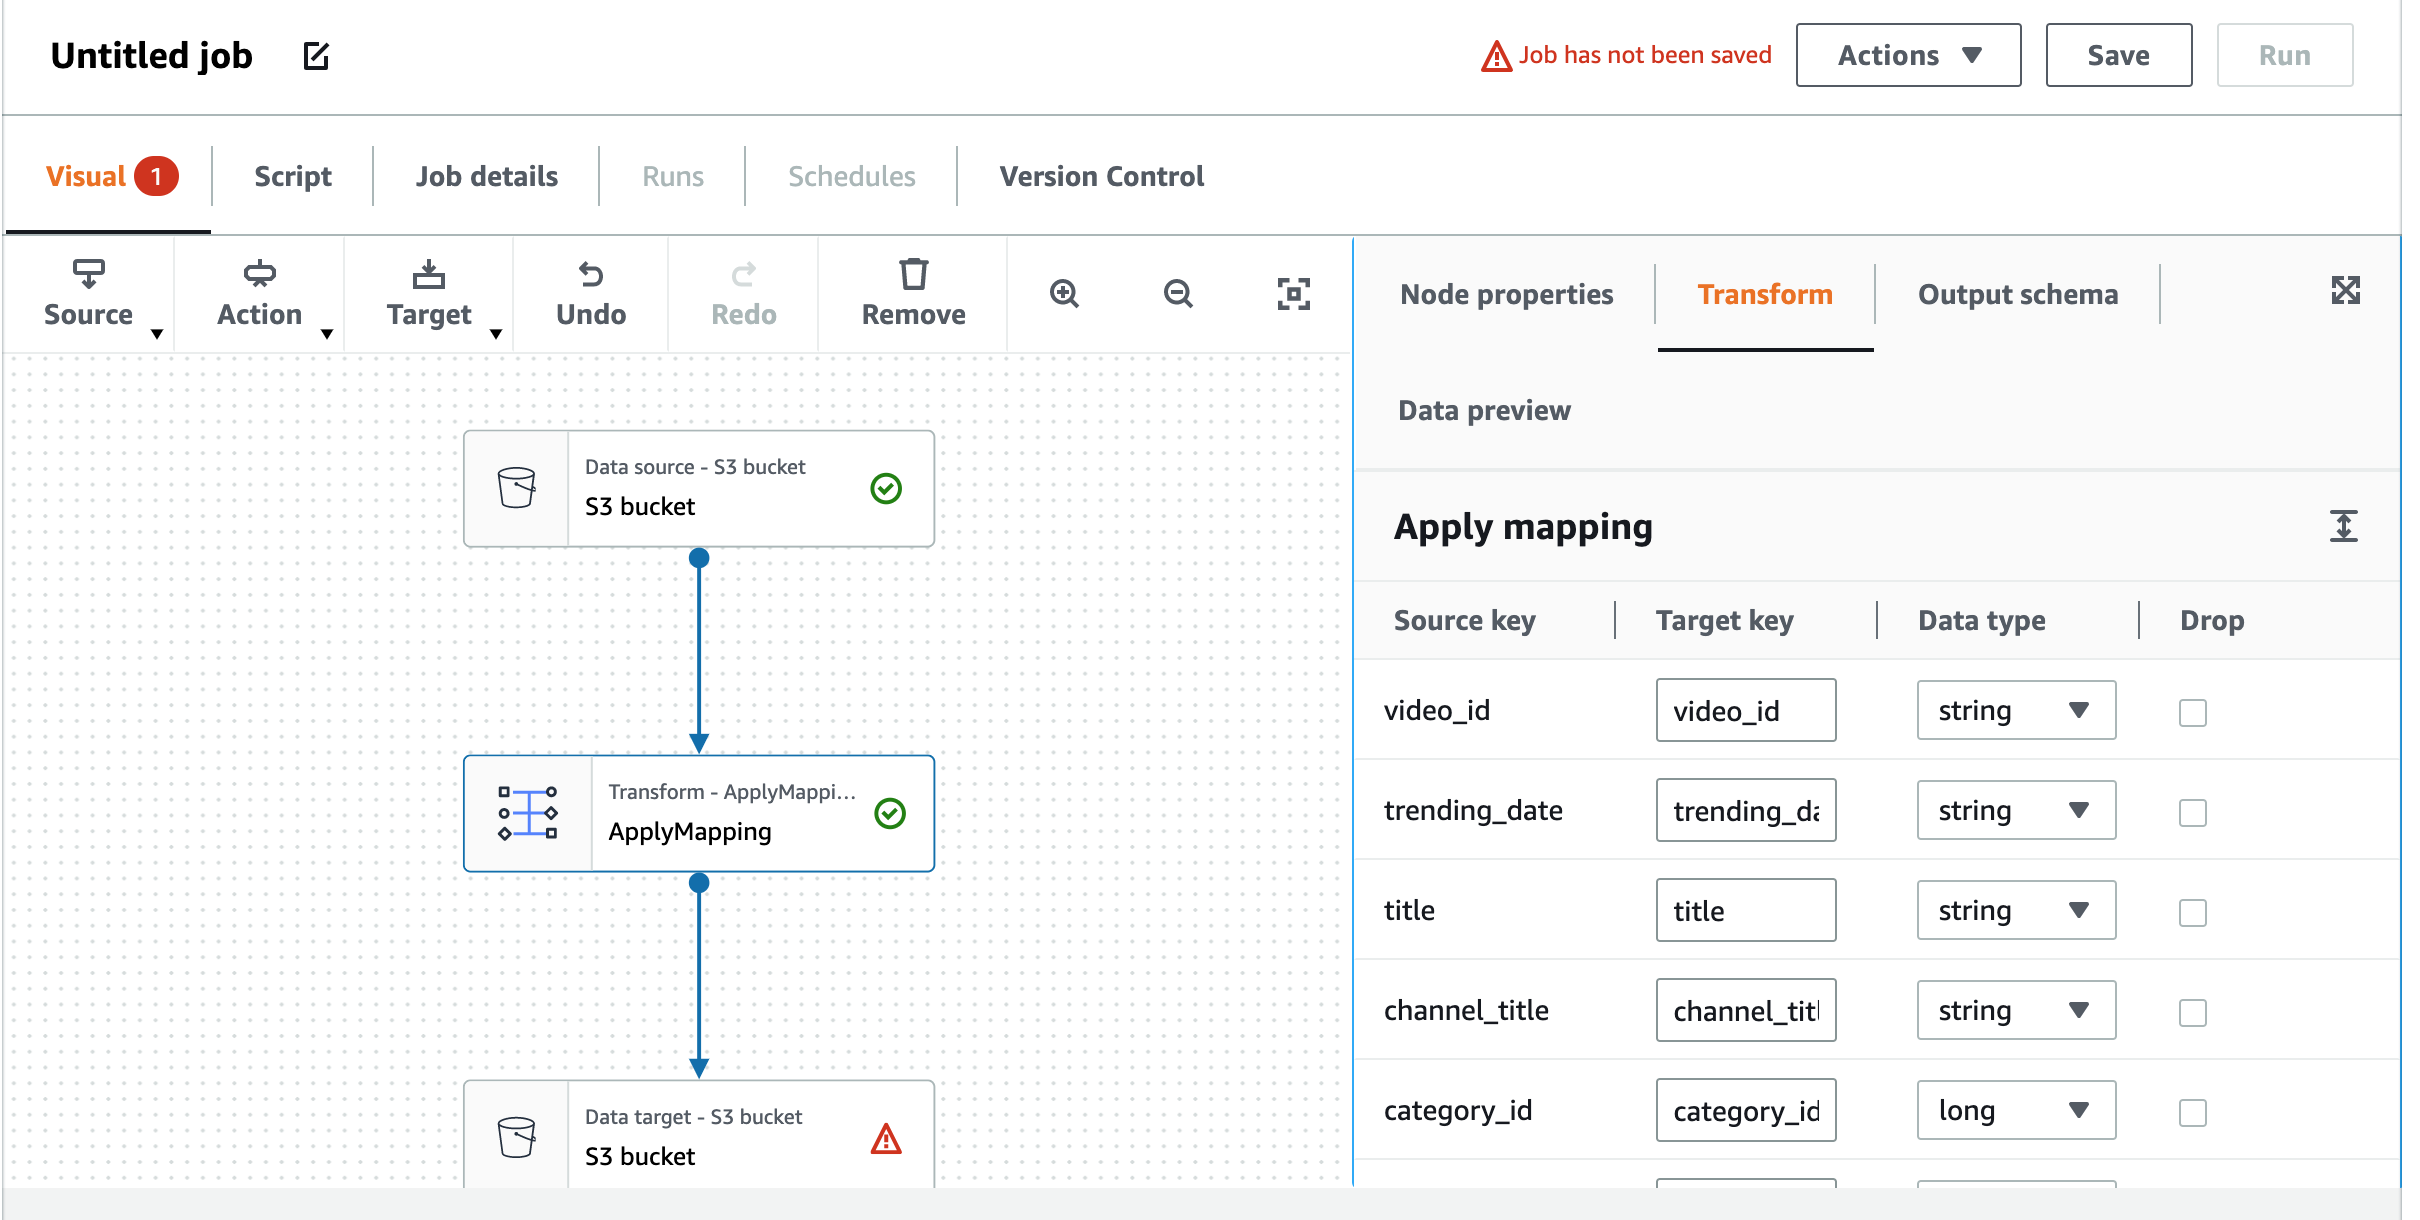
- Note: If you are interested in performing some a task other than transforming your data, you can click the 'action' drop down menu and select from a list of other actions, like in the image below. 
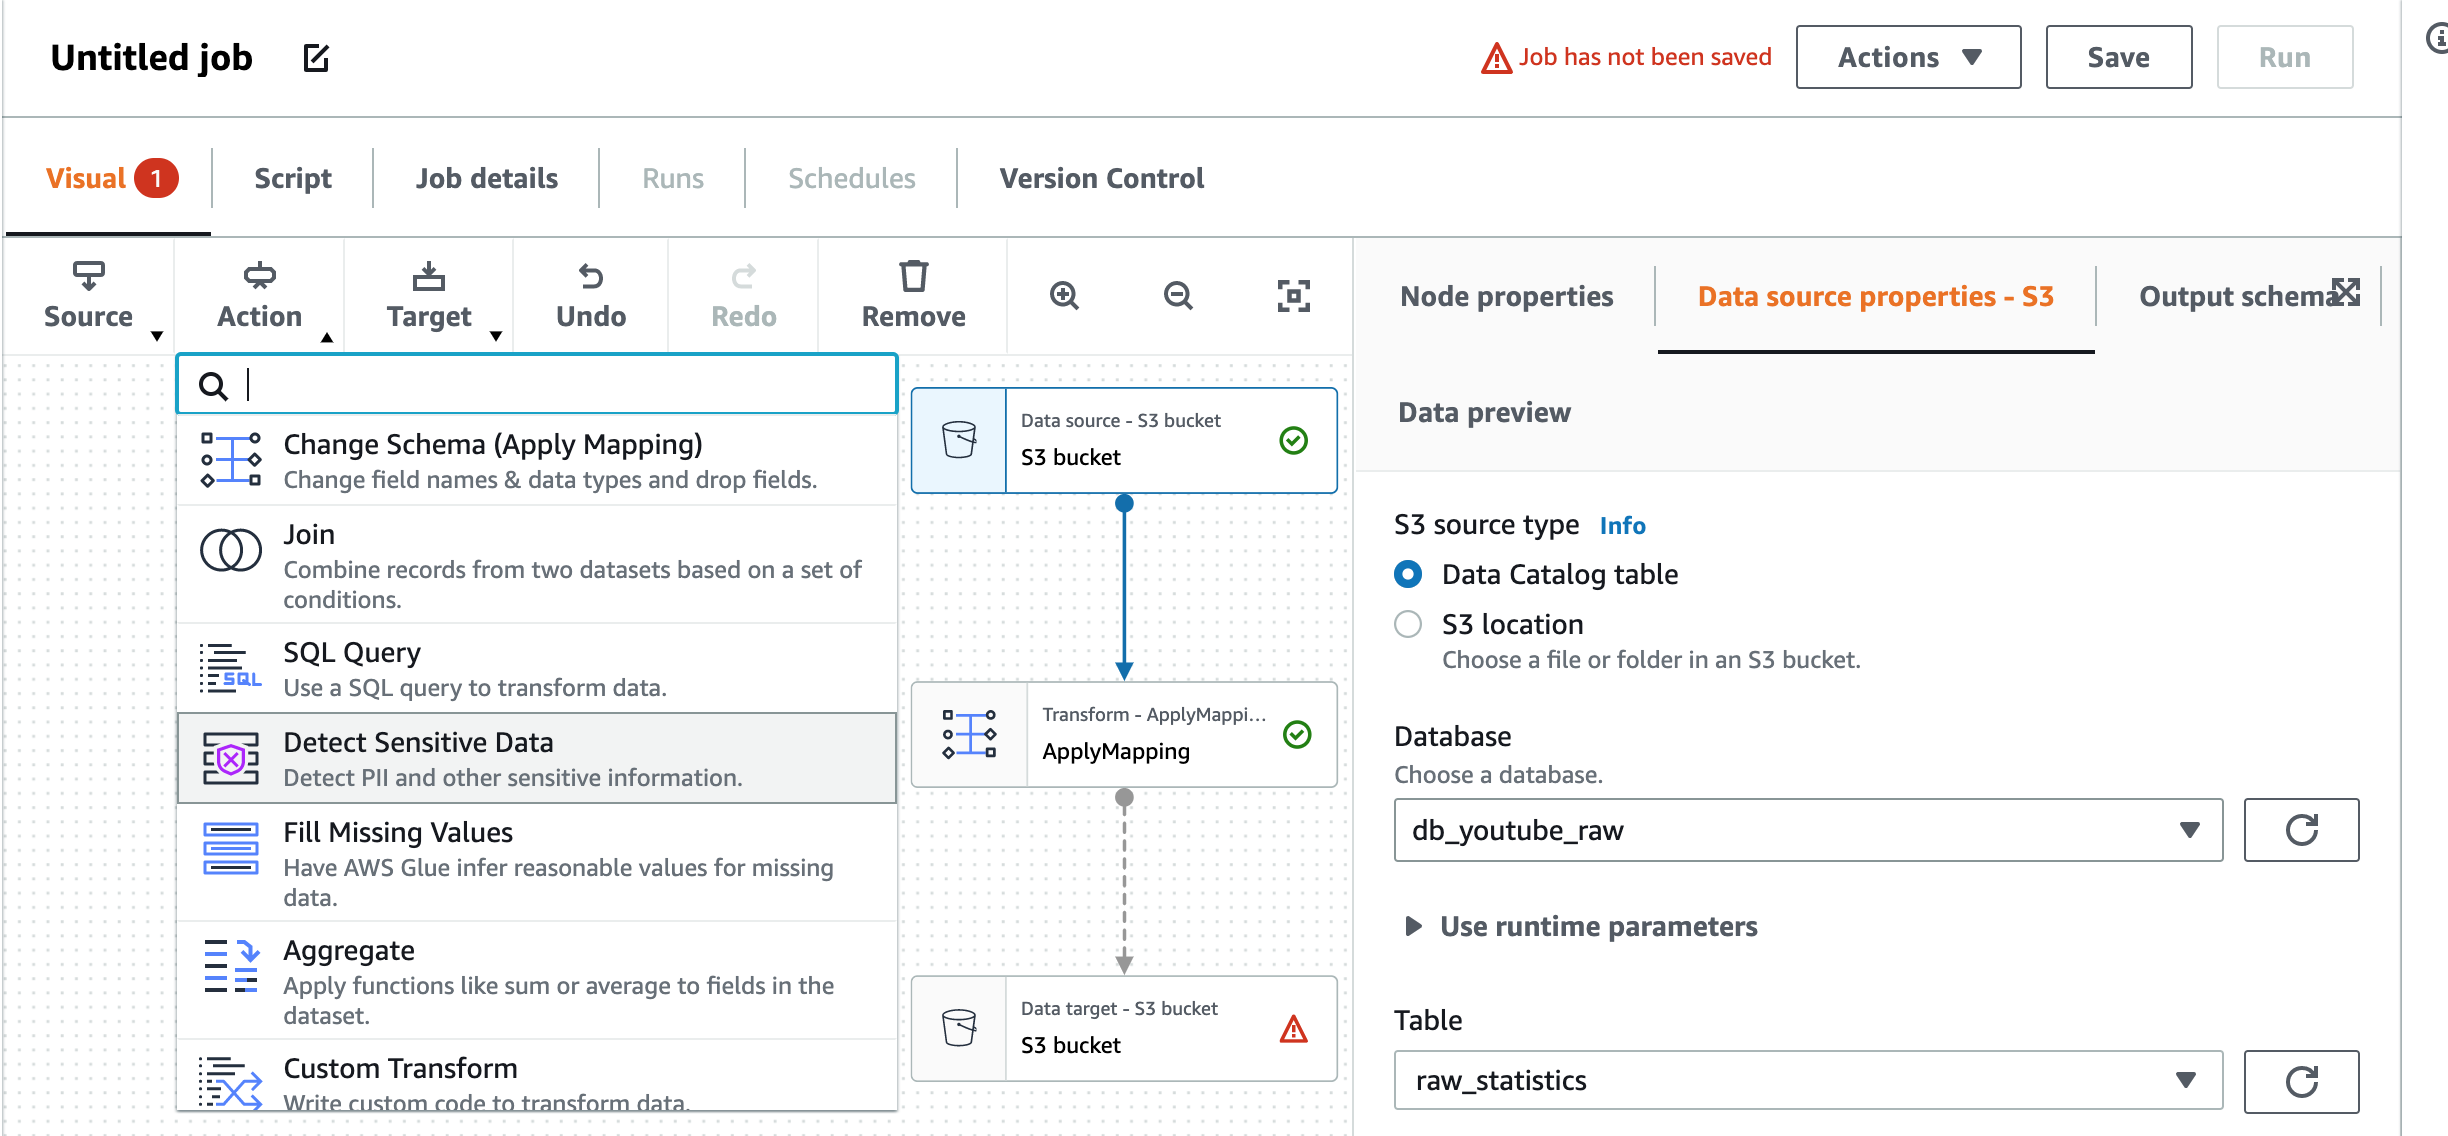
- **Step 3:** Once you adjusted all the desired parameters of your AWS Glue Job, click save and take a look at the Script tab in your new Glue Job.  This tab shows you the script that AWS automatically created based on the parameters you set up for your Glue Job is steps 1-2.  If you are familiar with programming, you can look through the autogenerated code line by line to see how your assignment is accomplished. 
    - **Below you can see the Glue script that AWS autogenerated to convert my 'raw' CSV files into 'cleansed' Parquet files.**  I also changed the data type of a few of the fields as part of the same Glue job. 
    - You can also wait until you’ve created your Parquet file with Glue Jobs, crawl that new Parquet file to create a Glue table, then change the datatypes within that Glue table.  The problem with this is that you would have to do this manually each time you add a new CSV file to your ‘raw’ s3 bucket.  It’s best practice to change data types as part of your Glue Job so it happens automatically when the JSON is converted to Parquet.

In [ ]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

############################### Added to template by dev  ###############################
from awsglue.dynamicframe import DynamicFrame

## @params: [JOB_NAME]
args = getResolvedOptions(sys.argv, ['JOB_NAME'])

sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)
## @type: DataSource
## @args: [database = "db_youtube_raw", table_name = "raw_statistics", transformation_ctx = "datasource0"]
## @return: datasource0
## @inputs: []
predicate_pushdown = "region in ('ca', 'gb', 'us')"
datasource0 = glueContext.create_dynamic_frame.from_catalog(database = "db_youtube_raw", table_name = "raw_statistics", transformation_ctx = "datasource0", push_down_predicate = predicate_pushdown)

## @type: ApplyMapping
## @args: [mapping = [("video_id", "string", "video_id", "string"), ("trending_date", "string", "trending_date", "string"), ("title", "string", "title", "string"), ("channel_title", "string", "channel_title", "string"), ("category_id", "long", "category_id", "long"), ("publish_time", "string", "publish_time", "string"), ("tags", "string", "tags", "string"), ("views", "long", "views", "long"), ("likes", "long", "likes", "long"), ("dislikes", "long", "dislikes", "long"), ("comment_count", "long", "comment_count", "long"), ("thumbnail_link", "string", "thumbnail_link", "string"), ("comments_disabled", "boolean", "comments_disabled", "boolean"), ("ratings_disabled", "boolean", "ratings_disabled", "boolean"), ("video_error_or_removed", "boolean", "video_error_or_removed", "boolean"), ("description", "string", "description", "string"), ("region", "string", "region", "string")], transformation_ctx = "applymapping1"]
## @return: applymapping1
## @inputs: [frame = datasource0]
applymapping1 = ApplyMapping.apply(frame = datasource0, mappings = [("video_id", "string", "video_id", "string"), ("trending_date", "string", "trending_date", "string"), ("title", "string", "title", "string"), ("channel_title", "string", "channel_title", "string"), ("category_id", "long", "category_id", "long"), ("publish_time", "string", "publish_time", "string"), ("tags", "string", "tags", "string"), ("views", "long", "views", "long"), ("likes", "long", "likes", "long"), ("dislikes", "long", "dislikes", "long"), ("comment_count", "long", "comment_count", "long"), ("thumbnail_link", "string", "thumbnail_link", "string"), ("comments_disabled", "boolean", "comments_disabled", "boolean"), ("ratings_disabled", "boolean", "ratings_disabled", "boolean"), ("video_error_or_removed", "boolean", "video_error_or_removed", "boolean"), ("description", "string", "description", "string"), ("region", "string", "region", "string")], transformation_ctx = "applymapping1")
## @type: ResolveChoice
## @args: [choice = "make_struct", transformation_ctx = "resolvechoice2"]
## @return: resolvechoice2
## @inputs: [frame = applymapping1]
resolvechoice2 = ResolveChoice.apply(frame = applymapping1, choice = "make_struct", transformation_ctx = "resolvechoice2")
## @type: DropNullFields
## @args: [transformation_ctx = "dropnullfields3"]
## @return: dropnullfields3
## @inputs: [frame = resolvechoice2]
dropnullfields3 = DropNullFields.apply(frame = resolvechoice2, transformation_ctx = "dropnullfields3")
## @type: DataSink
## @args: [connection_type = "s3", connection_options = {"path": "s3://bigdata-on-youtube-cleansed-apsoutheast-964154160632-dev/youtube/raw_statistics/"}, format = "parquet", transformation_ctx = "datasink4"]
## @return: datasink4
## @inputs: [frame = dropnullfields3]

############################### Added to template by dev  ###############################
datasink1 = dropnullfields3.toDF().coalesce(1)
df_final_output = DynamicFrame.fromDF(datasink1, glueContext, "df_final_output")
datasink4 = glueContext.write_dynamic_frame.from_options(frame = df_final_output, connection_type = "s3", connection_options = {"path": "s3://bigdata-on-youtube-cleansed-apsoutheast-964154160632-dev/youtube/raw_statistics/", "partitionKeys": ["region"]}, format = "parquet", transformation_ctx = "datasink4")

############################### Added to template by dev  ###############################
job.commit()

- **Step 4:** Click run and check for errors. If your Glue Job ran correctly, you should now have a new Parquet file stored in the 'target' bucket you selected when setting up your Glue job. 
- **Step 5:** Crawl your newly created Parquet file in your target s3 bucket in order to add it to your Glue database as a table that can be queried. Write a simple SQL Query in AWS Athena to test whether your Glue Job and Crawler performed their jobs correctly.  
    - Below you can see the query I used to test my Glue Job and Crawler
    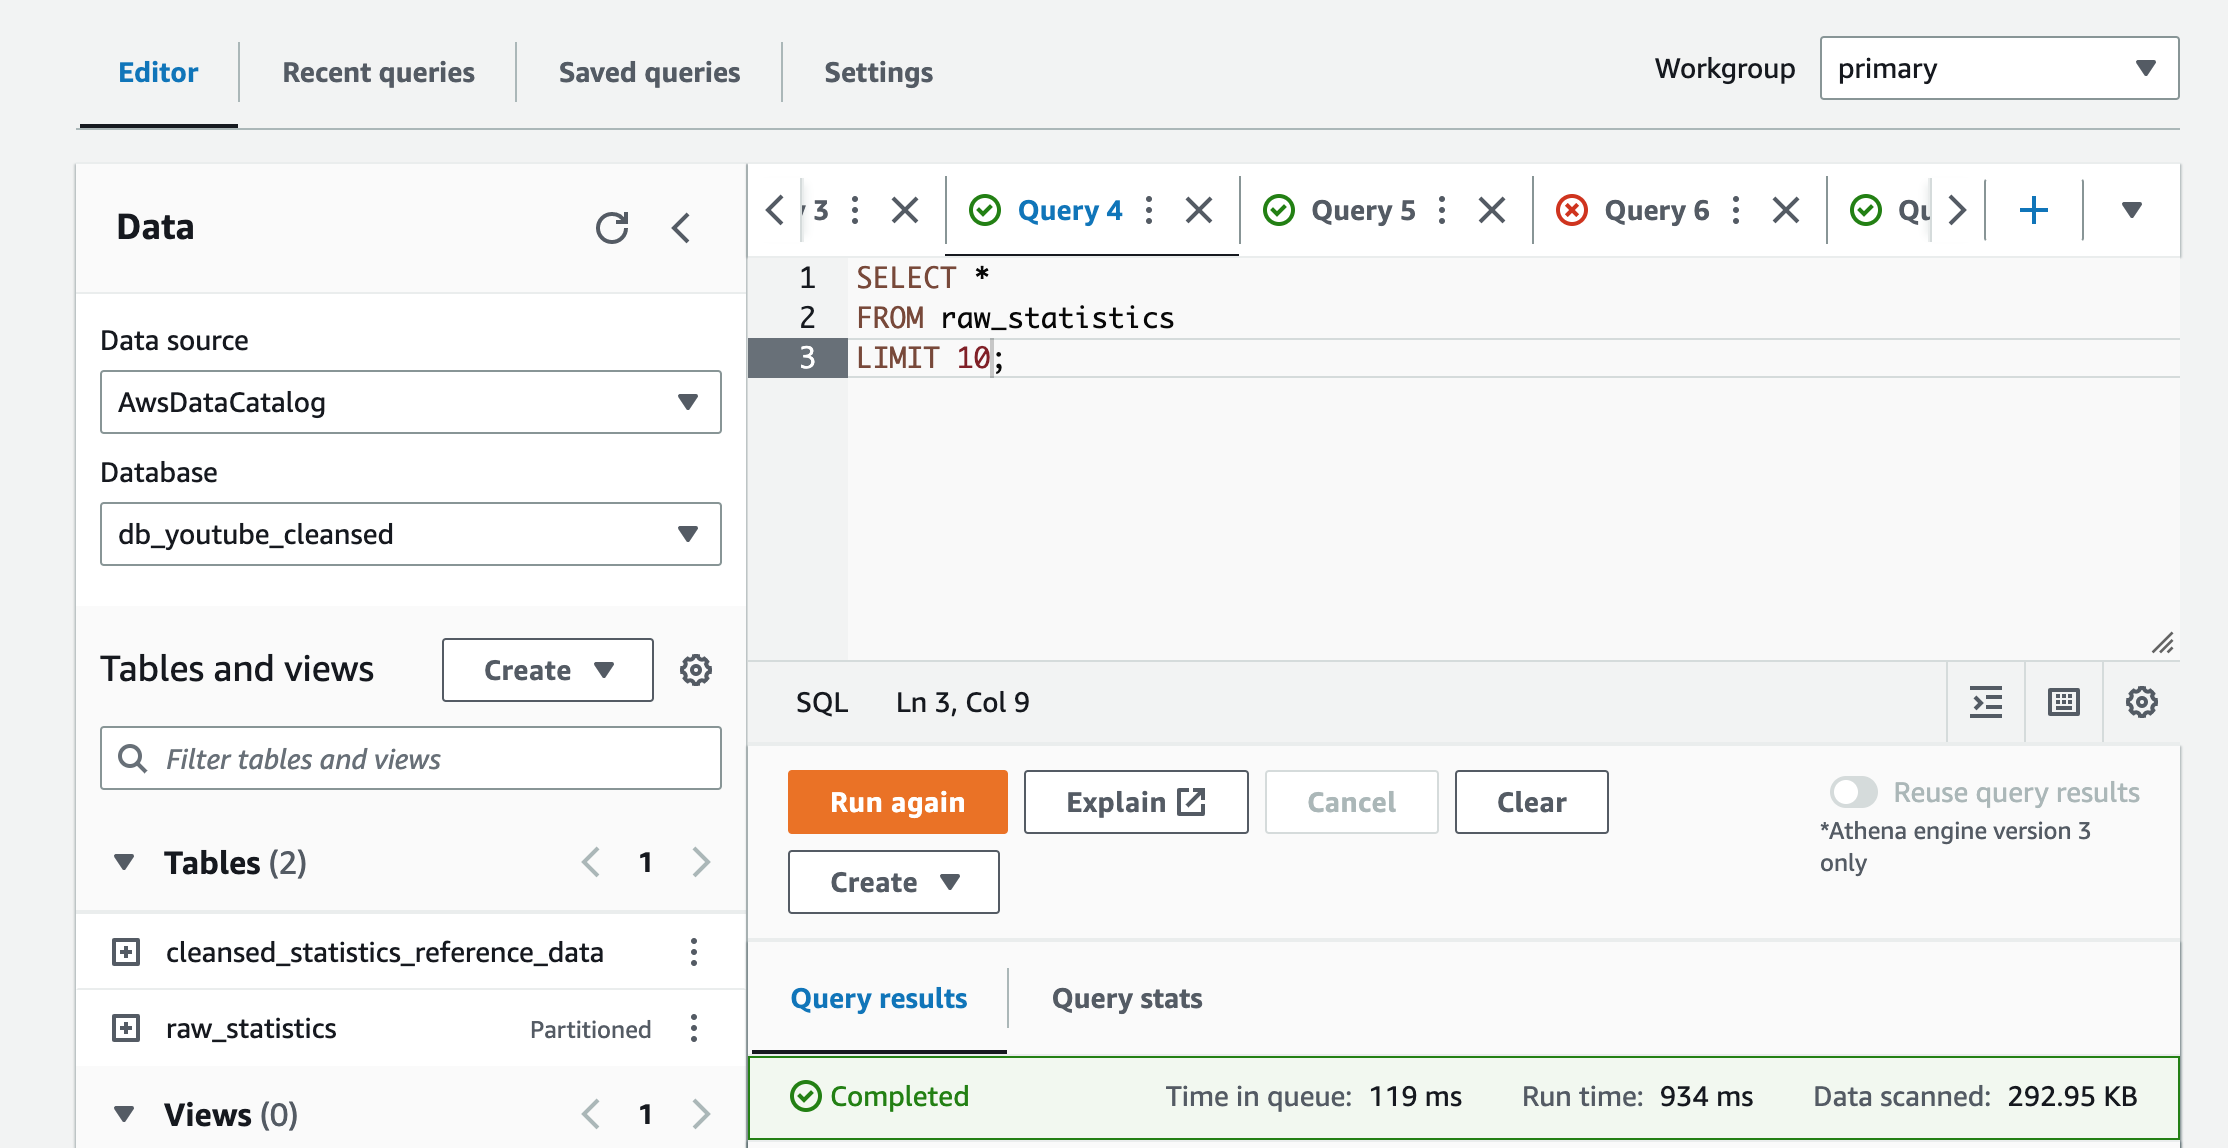
    - Results of query
    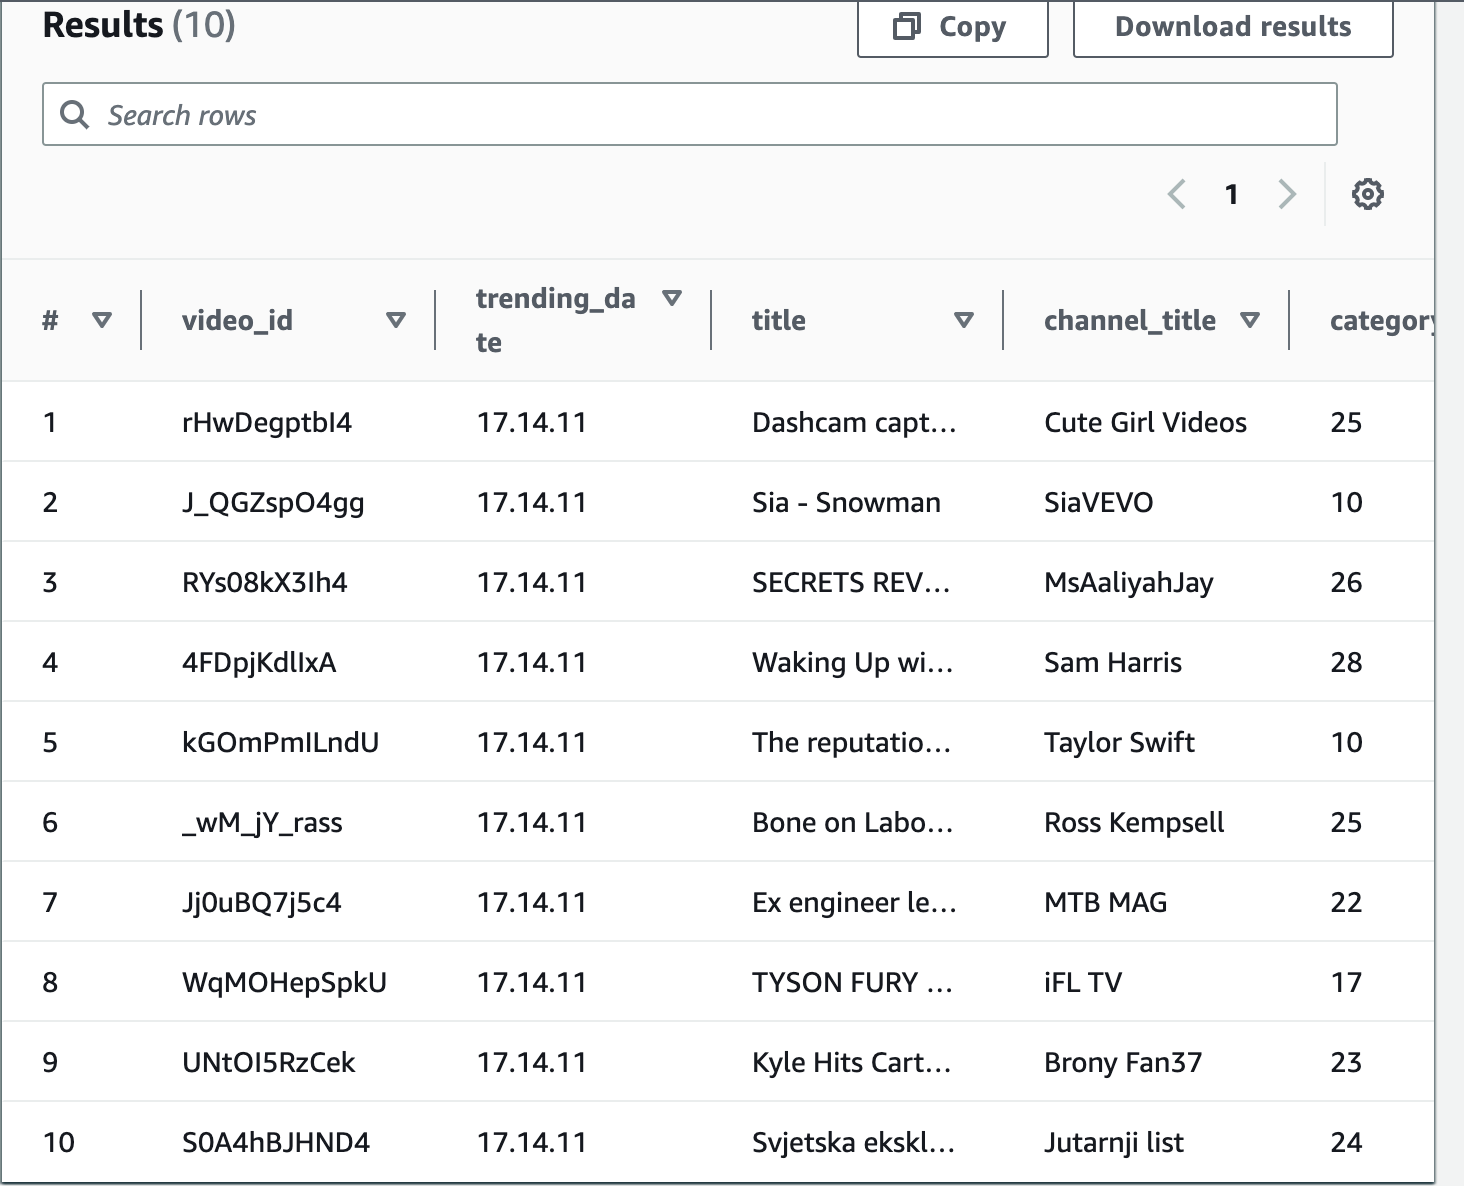

## Part 6: Join all Parquet files into final table containing all original data
Now that you have both your original JSON and CSV files as Parquet files, you can query them easily using Glue tables.  But what if you want to query all your Glue tables at once? You'd need to use a Join in each SQL query you wrote, which could become tedious and also uses more AWS processing power, therefore raising costs.  Instead we can create a second Glue Job that automates this join and stores a final result as one table with ALL of your data.  This table can then be used to query the data or connect with a BI tool (QuickSight, Tableau, PowerBI) to create visualizations, dashboards, or presentations

- **Step 1:** Create a new Job in AWS Glue: Go to Glue and click jobs in the left column, then click 'Create'. 
- **Step 2:** Select both of your Glue tables ('JSON->Parquet table data' and 'CSV->Parquet table data') as data 'Source's.
- **Step 3:** Select 'Join' as your 'Transform' Event, selecting the field of each table that you want to join the data on.  Make sure to correctly specify which type of Join (Full, Inner, Left, Right) you want. 
- **Step 4:** Select a 'target' location for your newly joined data.  I created a new empty s3 bucket called 'bigdata-on-youtube-analysis-apssoutheast-964154160632-dev'. Also select the format you want your data stored in (Parquet, CSV, JSON) 
    - If you choose to store this newly joined file in an s3 bucket, make sure the select the "Create a table in the Data Catalog and on subsequent runs, update the schema and add new partitions" option as part of your 'target event', otherwise you will need to crawl the new file manually in order to query it with Athena. 

Below you can see an overview of the Join I automated using Glue Job.  Keep in mind that yours may not look exactly like this depending on what you're trying to do. 
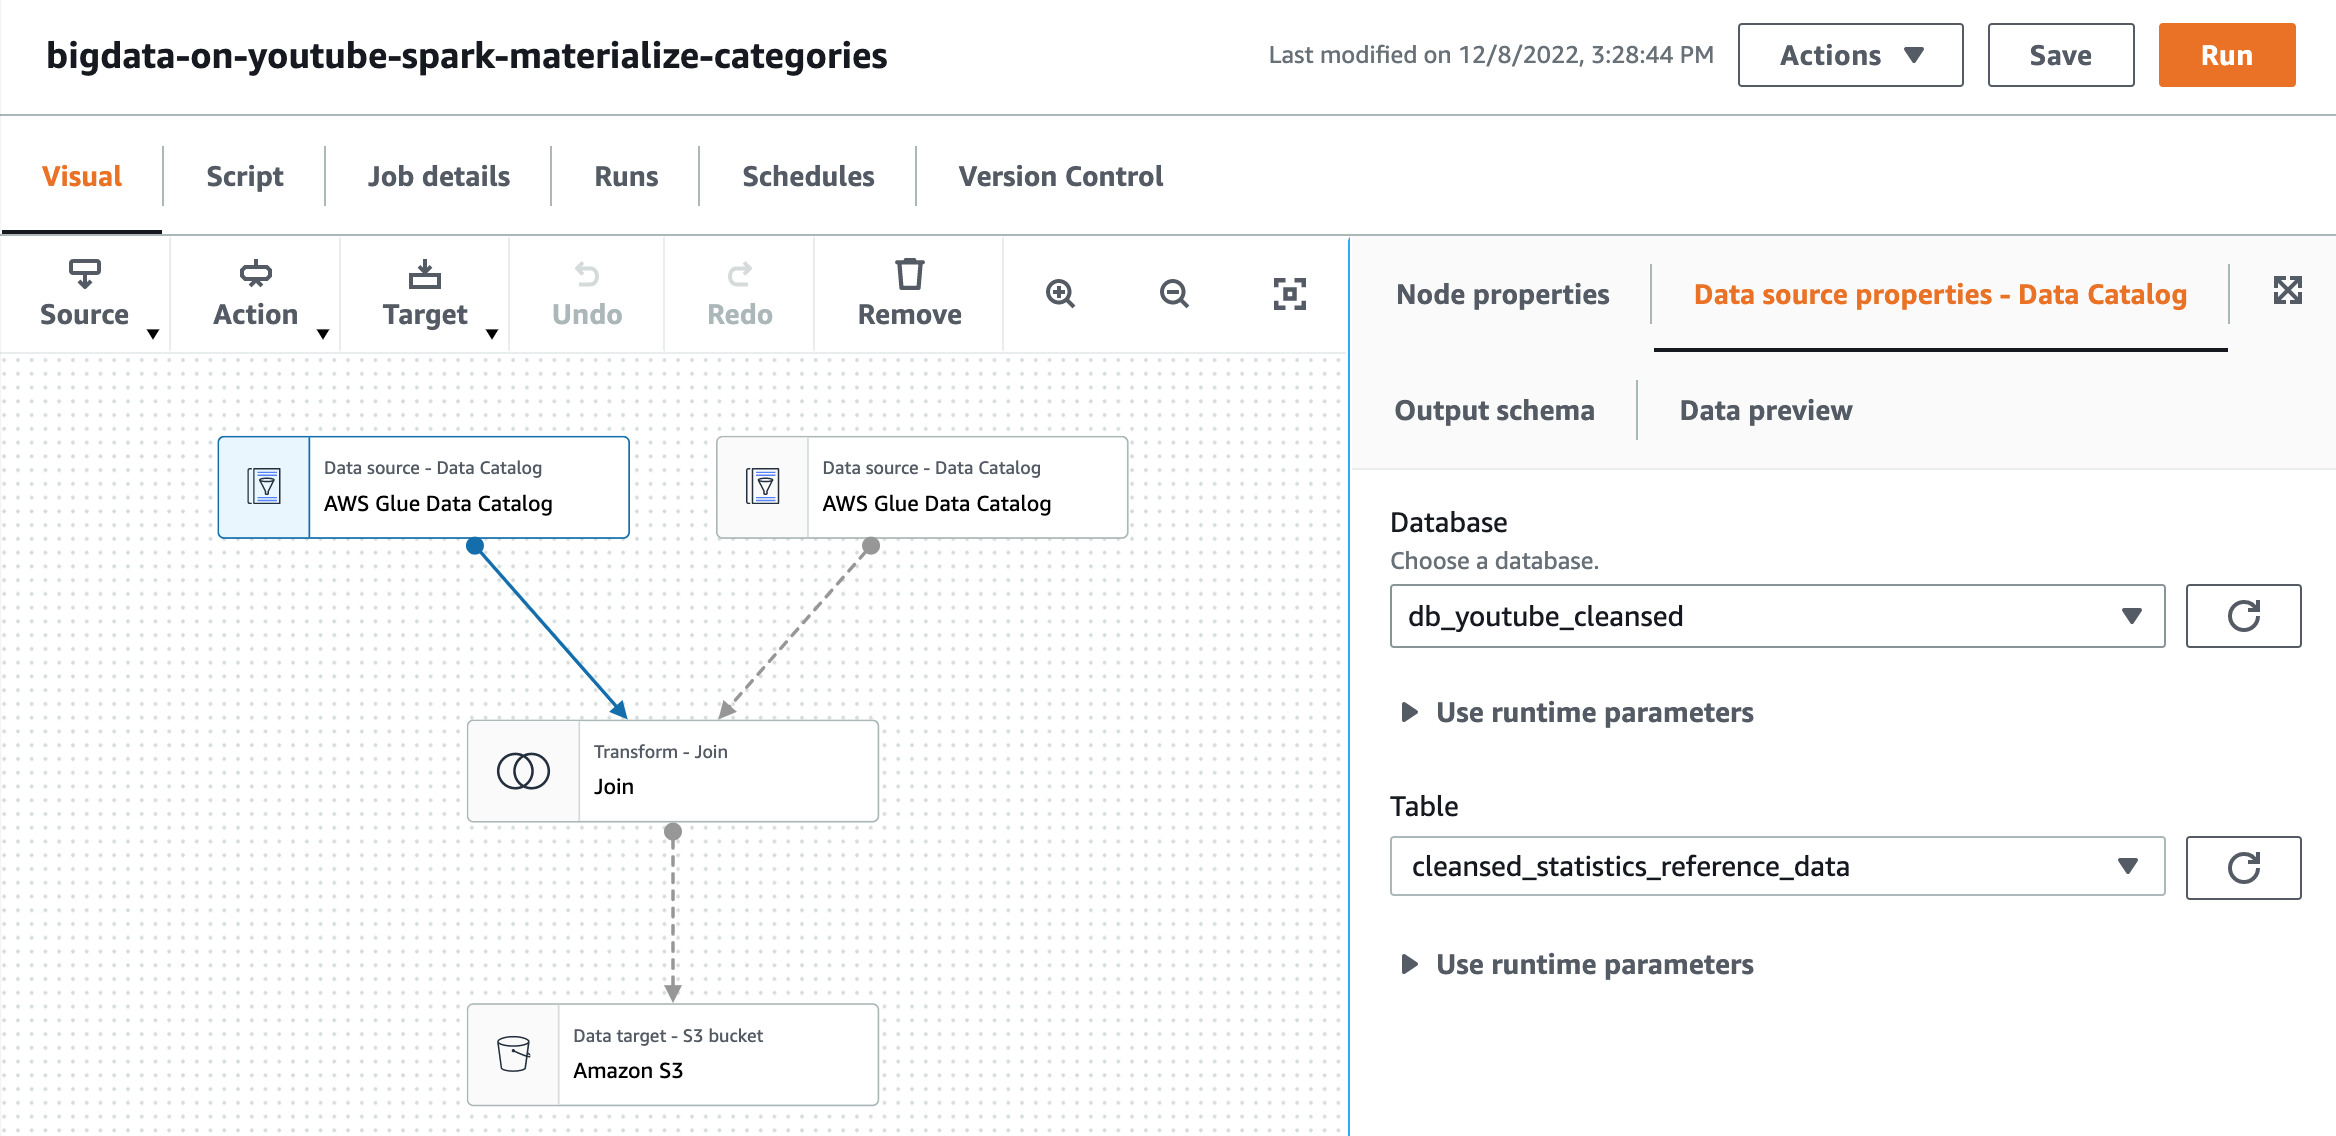

## Part 7: Add Trigger to Lambda Function 
At this point we have essentially finished our ETL pipeline and our data can be easily queried with SQL.  
**Completed Steps**
- JSON files->converted to Apache Parquet files (Lambda)->crawled Parquet files (Glue Crawler)creating queryable tables in Glue -> queried tables(Athena)
- CSV files->converted to Apache Parquet files (Glue Job)->crawled Parquet files (Glue Crawler)creating queryable tables in Glue -> queried tables(Athena)

While our files are converted, what if we wanted to send more YouTube files through the pipeline? We would have to repeat each Part above for each new file.  That's a lot of work. Luckily, AWS allows us to use 'triggers' to automate these steps.

- A **trigger** is an event that causes a specific action to be taken. Triggers can be used in various AWS services to automate tasks or processes.

**Our Triggers:**
- **1st Trigger**: Add a trigger to your existing Lambda function that causes the Lambda function to run automatically whenever new files are added to your s3 bucket with 'raw' data.  This is very easy to do. Click on your existing function in Lambda, then click 'add trigger'.  Below you can see come of the parameter options that need to be adjusted when setting up your trigger
    - You can test that your trigger is working correctly by adding another JSON file to your raw s3 bucket and seeing if Lambda is triggered into making a parquet file out of it and place that Parquet file in your ‘cleansed’ s3 bucket.
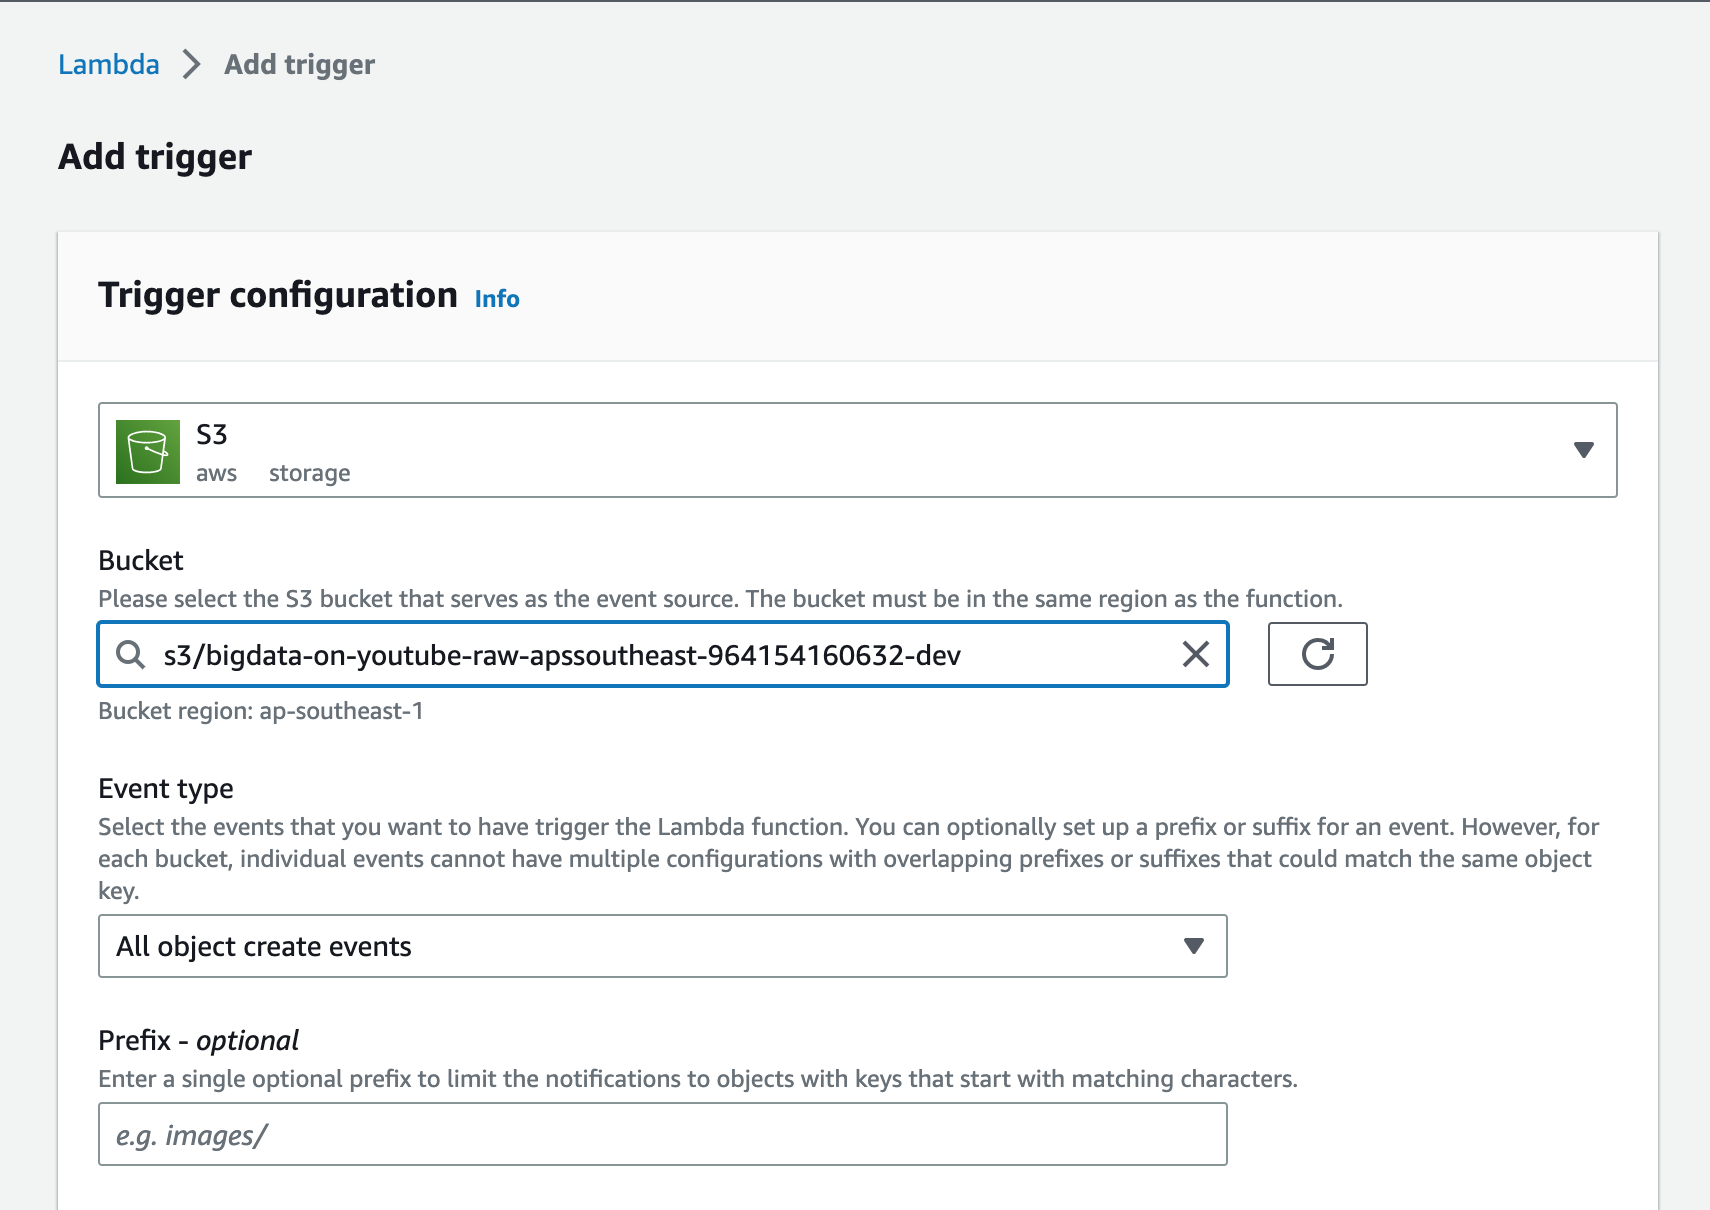


## Part 8: Create Workflow in AWS Glue 
Next we will automate the process of converting our CSVs to Parquets and crawling those Parquets to create tables in Glue.  This process is similar how we created a trigger for our Lambda function, however Glue Workflows provide us with even more options with regards to automating our ETL. 
- **Step 1:** Create Glue workflow. Enter AWS Glue and click 'workflows' in  the left column, then click add workflow. 
- **Step 2:** Click 'add Trigger' in your new workflow. You can select how often you want this trigger to fire here. I selected 'hourly' as this first trigger will cause our previous Glue Job (CSV to Parquet) to run hourly on any new files added to the ‘raw’ s3 bucket in the last hour.  At this stage you should have a visual like the one below. 
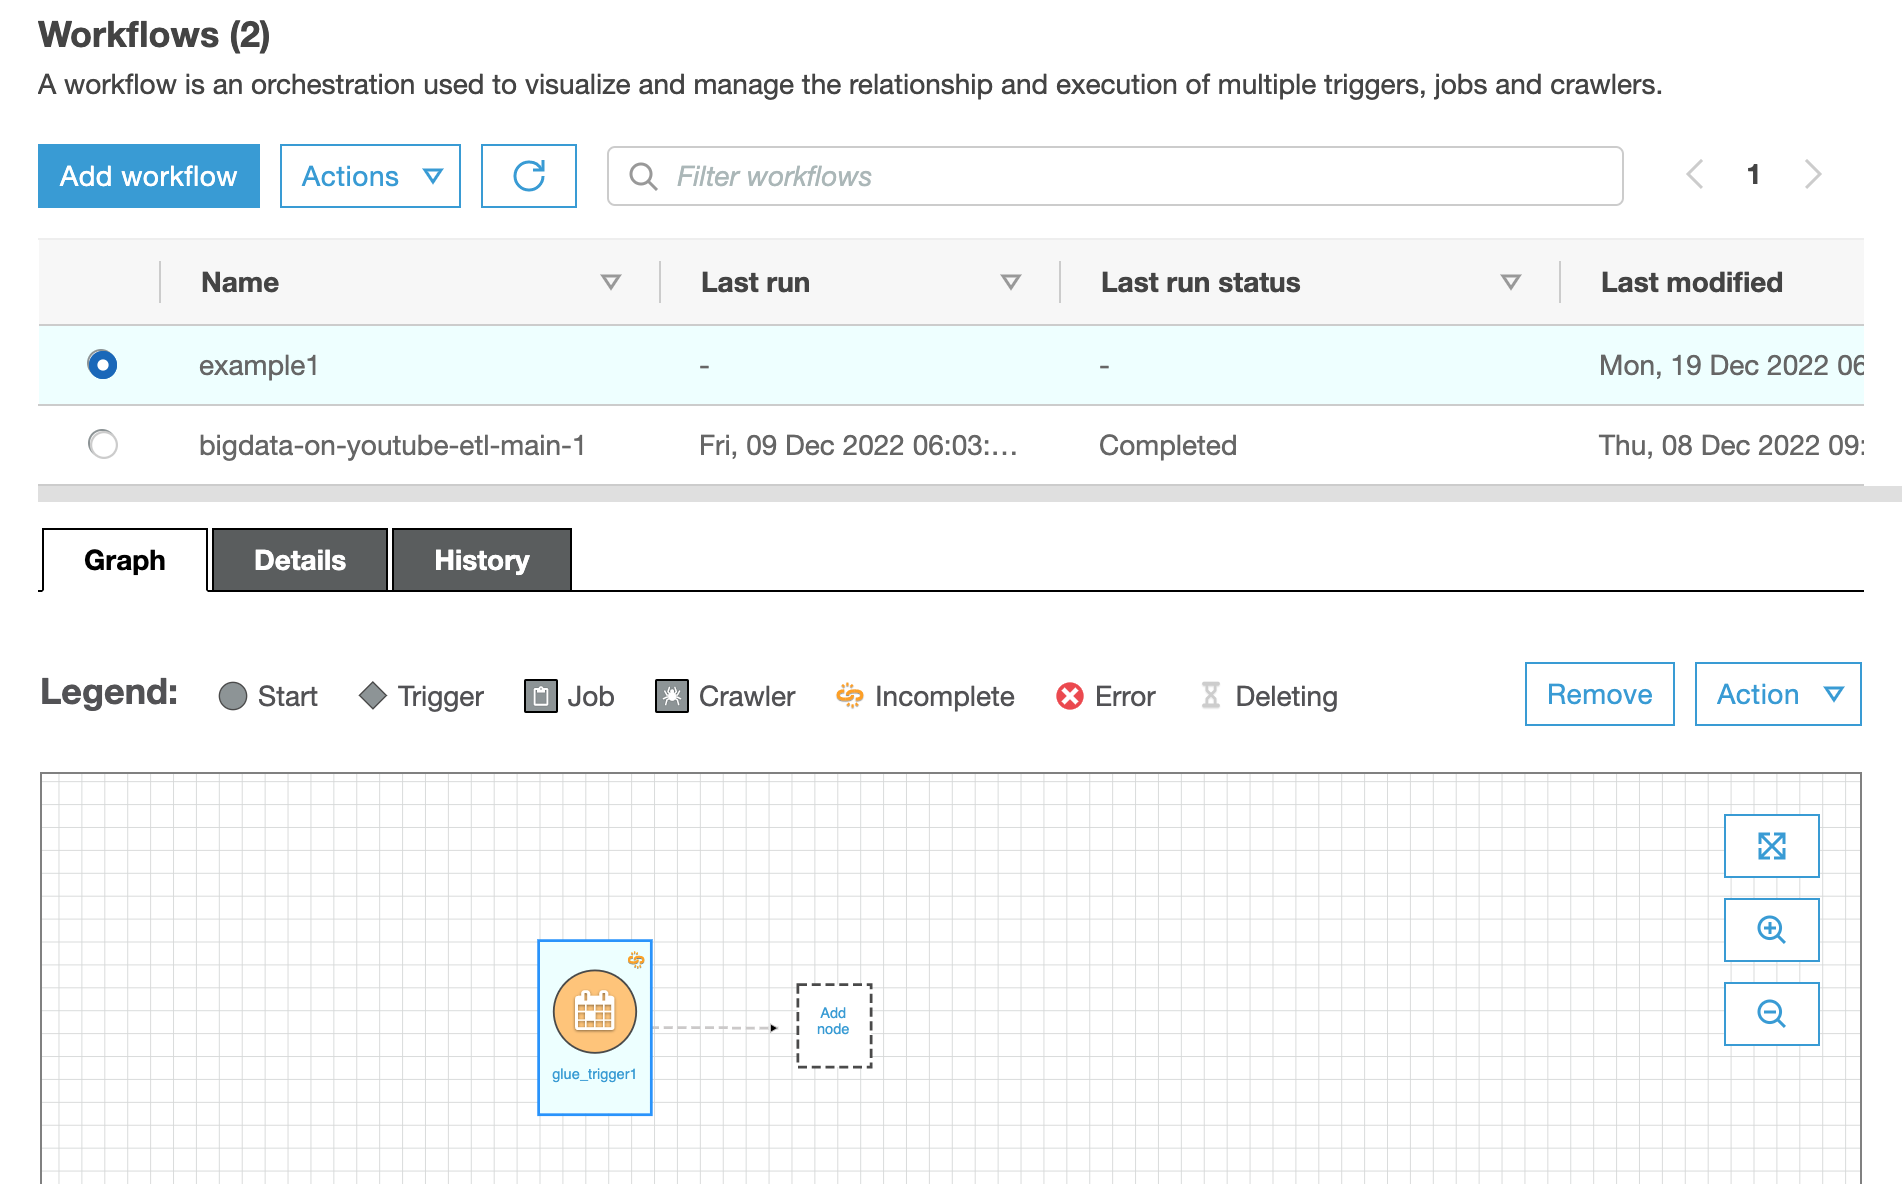
- **Step 3:** Add your already existing Glue Job(CSV to parquet) to the workflow after the trigger. Once complete, your workflow should now look something like this.
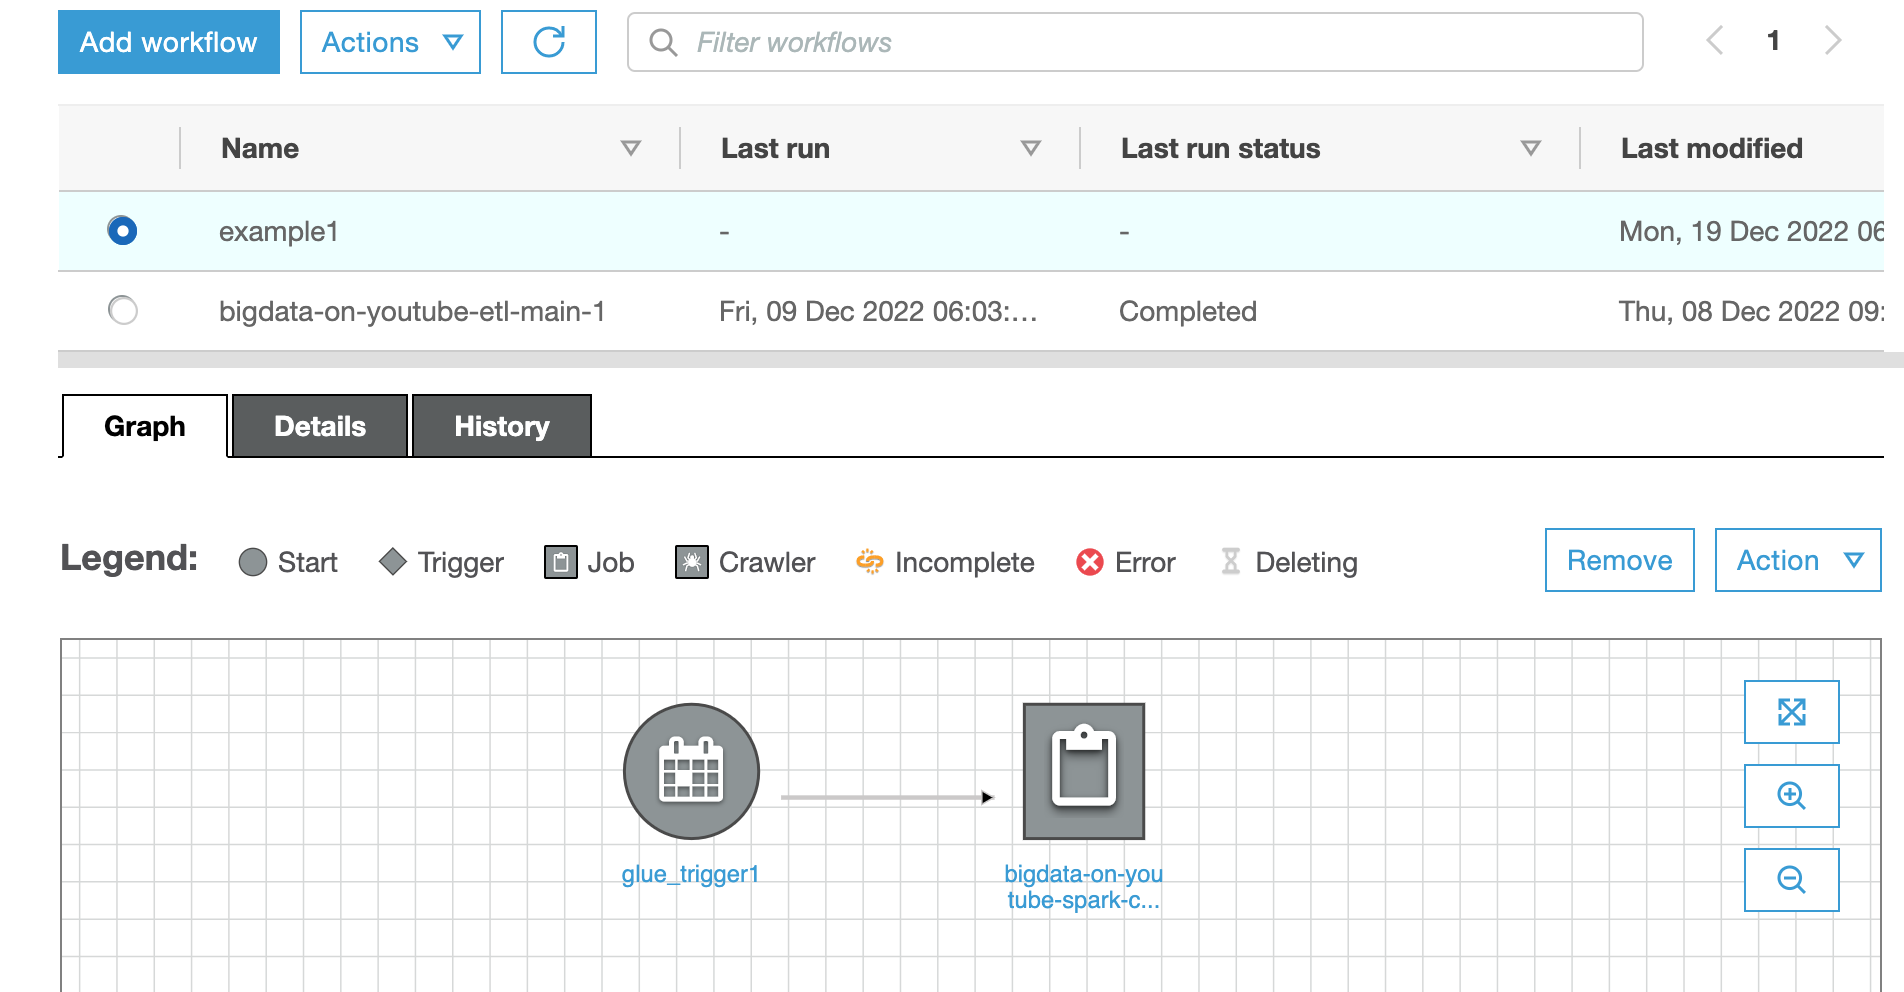
- **Step 4:** Add a second trigger after your glue job (CSV to parquet) that fires 'after ANY watched event'.  This will mean that the trigger will fire whenever a new file is created by your Glue job in part 3. After this stage your workflow should look like the one below. 
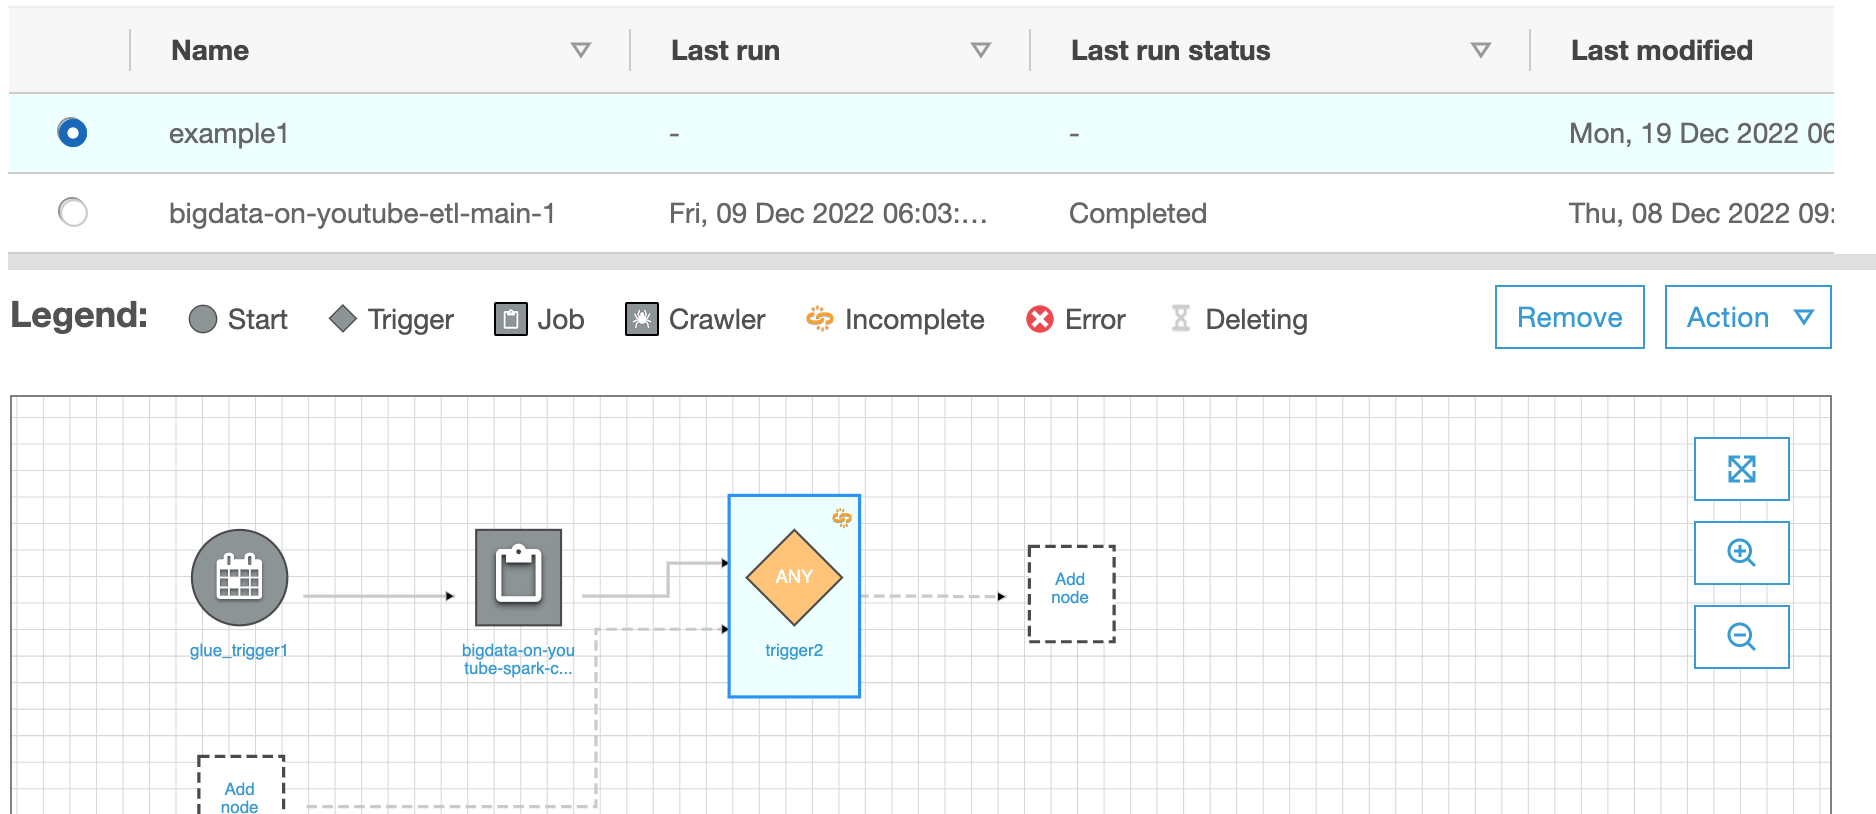
- **Step 5:** Add your Glue Join event (from Part 6) as the last step of your workflow.  This means that once step 3 of your workflow converts new CSV files into Parquet files, those parquet files will then trigger your Join Glue job to join the new files data with all existing data. Once complete your workflow should look something like this
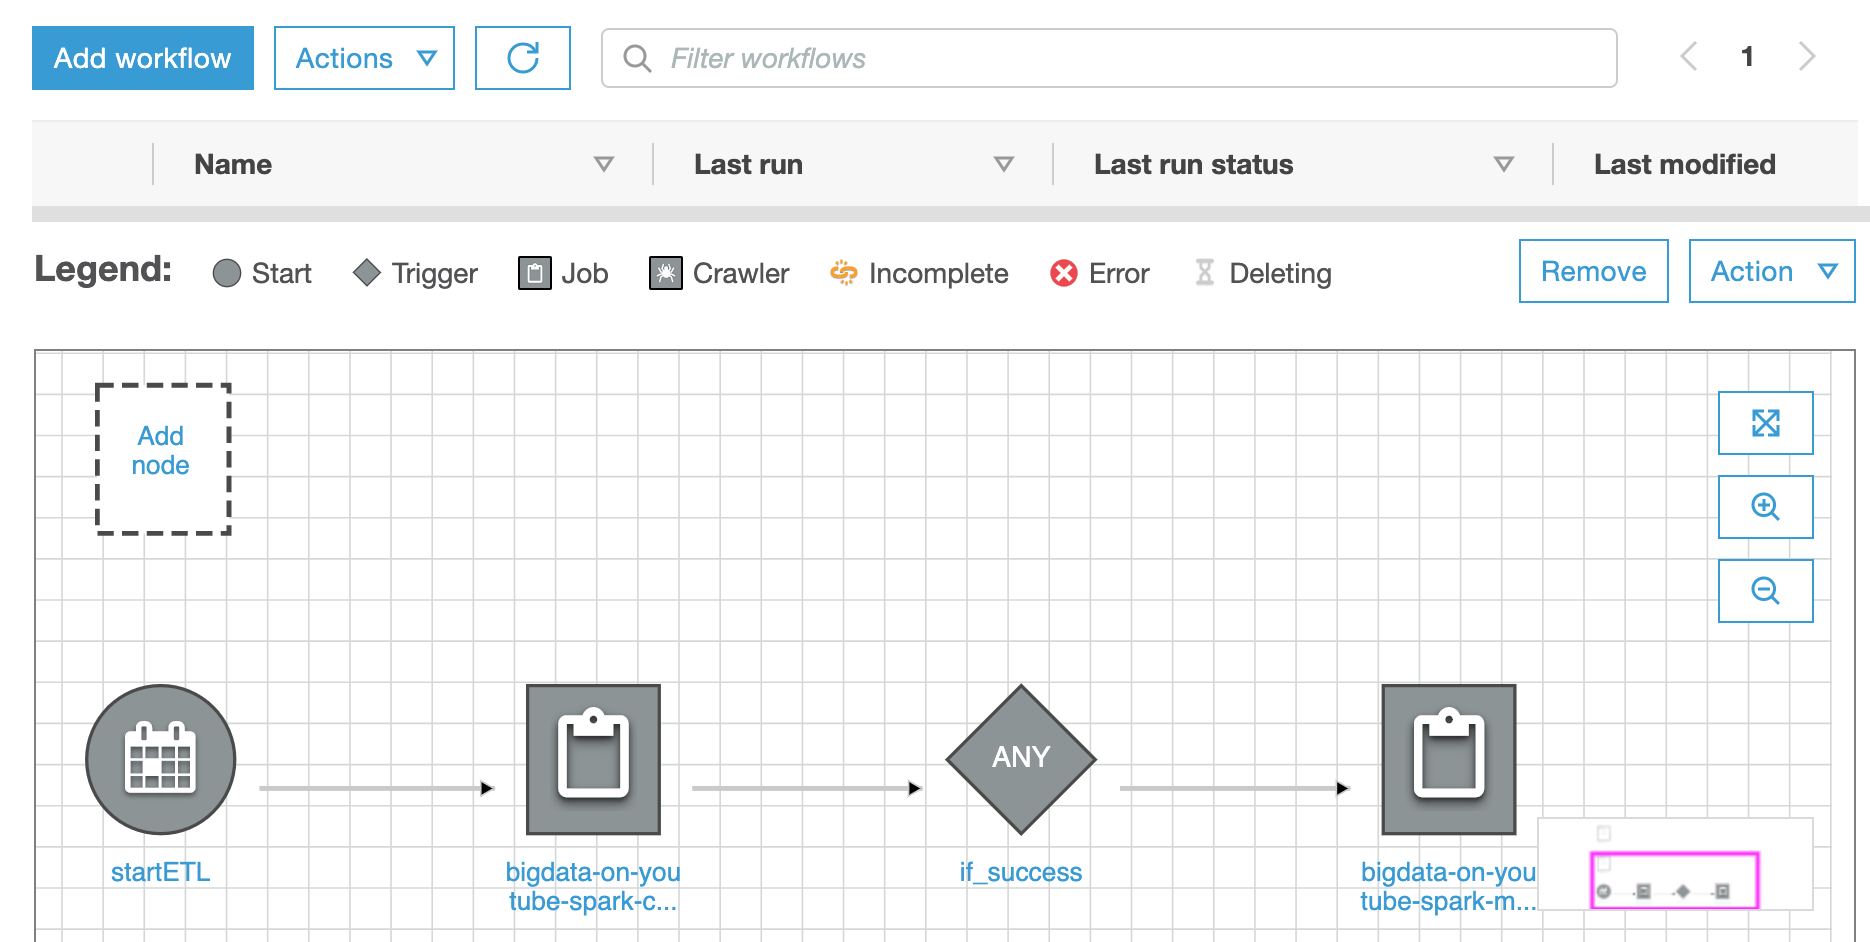

OK! Your workflow is finally done! Or is it? You can test it by adding new files to the raw s3 bucket. If the triggers and workflow are doing their job, the first trigger should fire within an hour, causing your first Glue Job (CSV to Parquet) to convert any new CSV files in the raw s3 bucket into parquet files, once these new parquet files are created and added to your 'cleansed' s3 bucket, the second trigger in the workflow will fire and cause your second Glue Job (Joining all parquets) to join this new data to a final cumulative data table. This final cumulative table now contains all our data (JSON and CSV) is queryable format.

## Part 9: Done! Connect your Pipeline to QuickSight and Visualize data.
So you've tested your pipeline by querying Athena. After all this work it can be easy to forget that this entire process is only part of the data lifecycle.  This pipeline was built to make life easier for Data Analysts or Data Scientists in your team when they do their analysis or predictive learning work. So for our final step we need to connect our pipeline to some of the tools they might use and make sure everything is running smoothly. 
- I used Amazon QuickSight BI tool to do a simple exploratory analysis of the YouTube data.  You can see a snapshot of the various visuals I created below. 
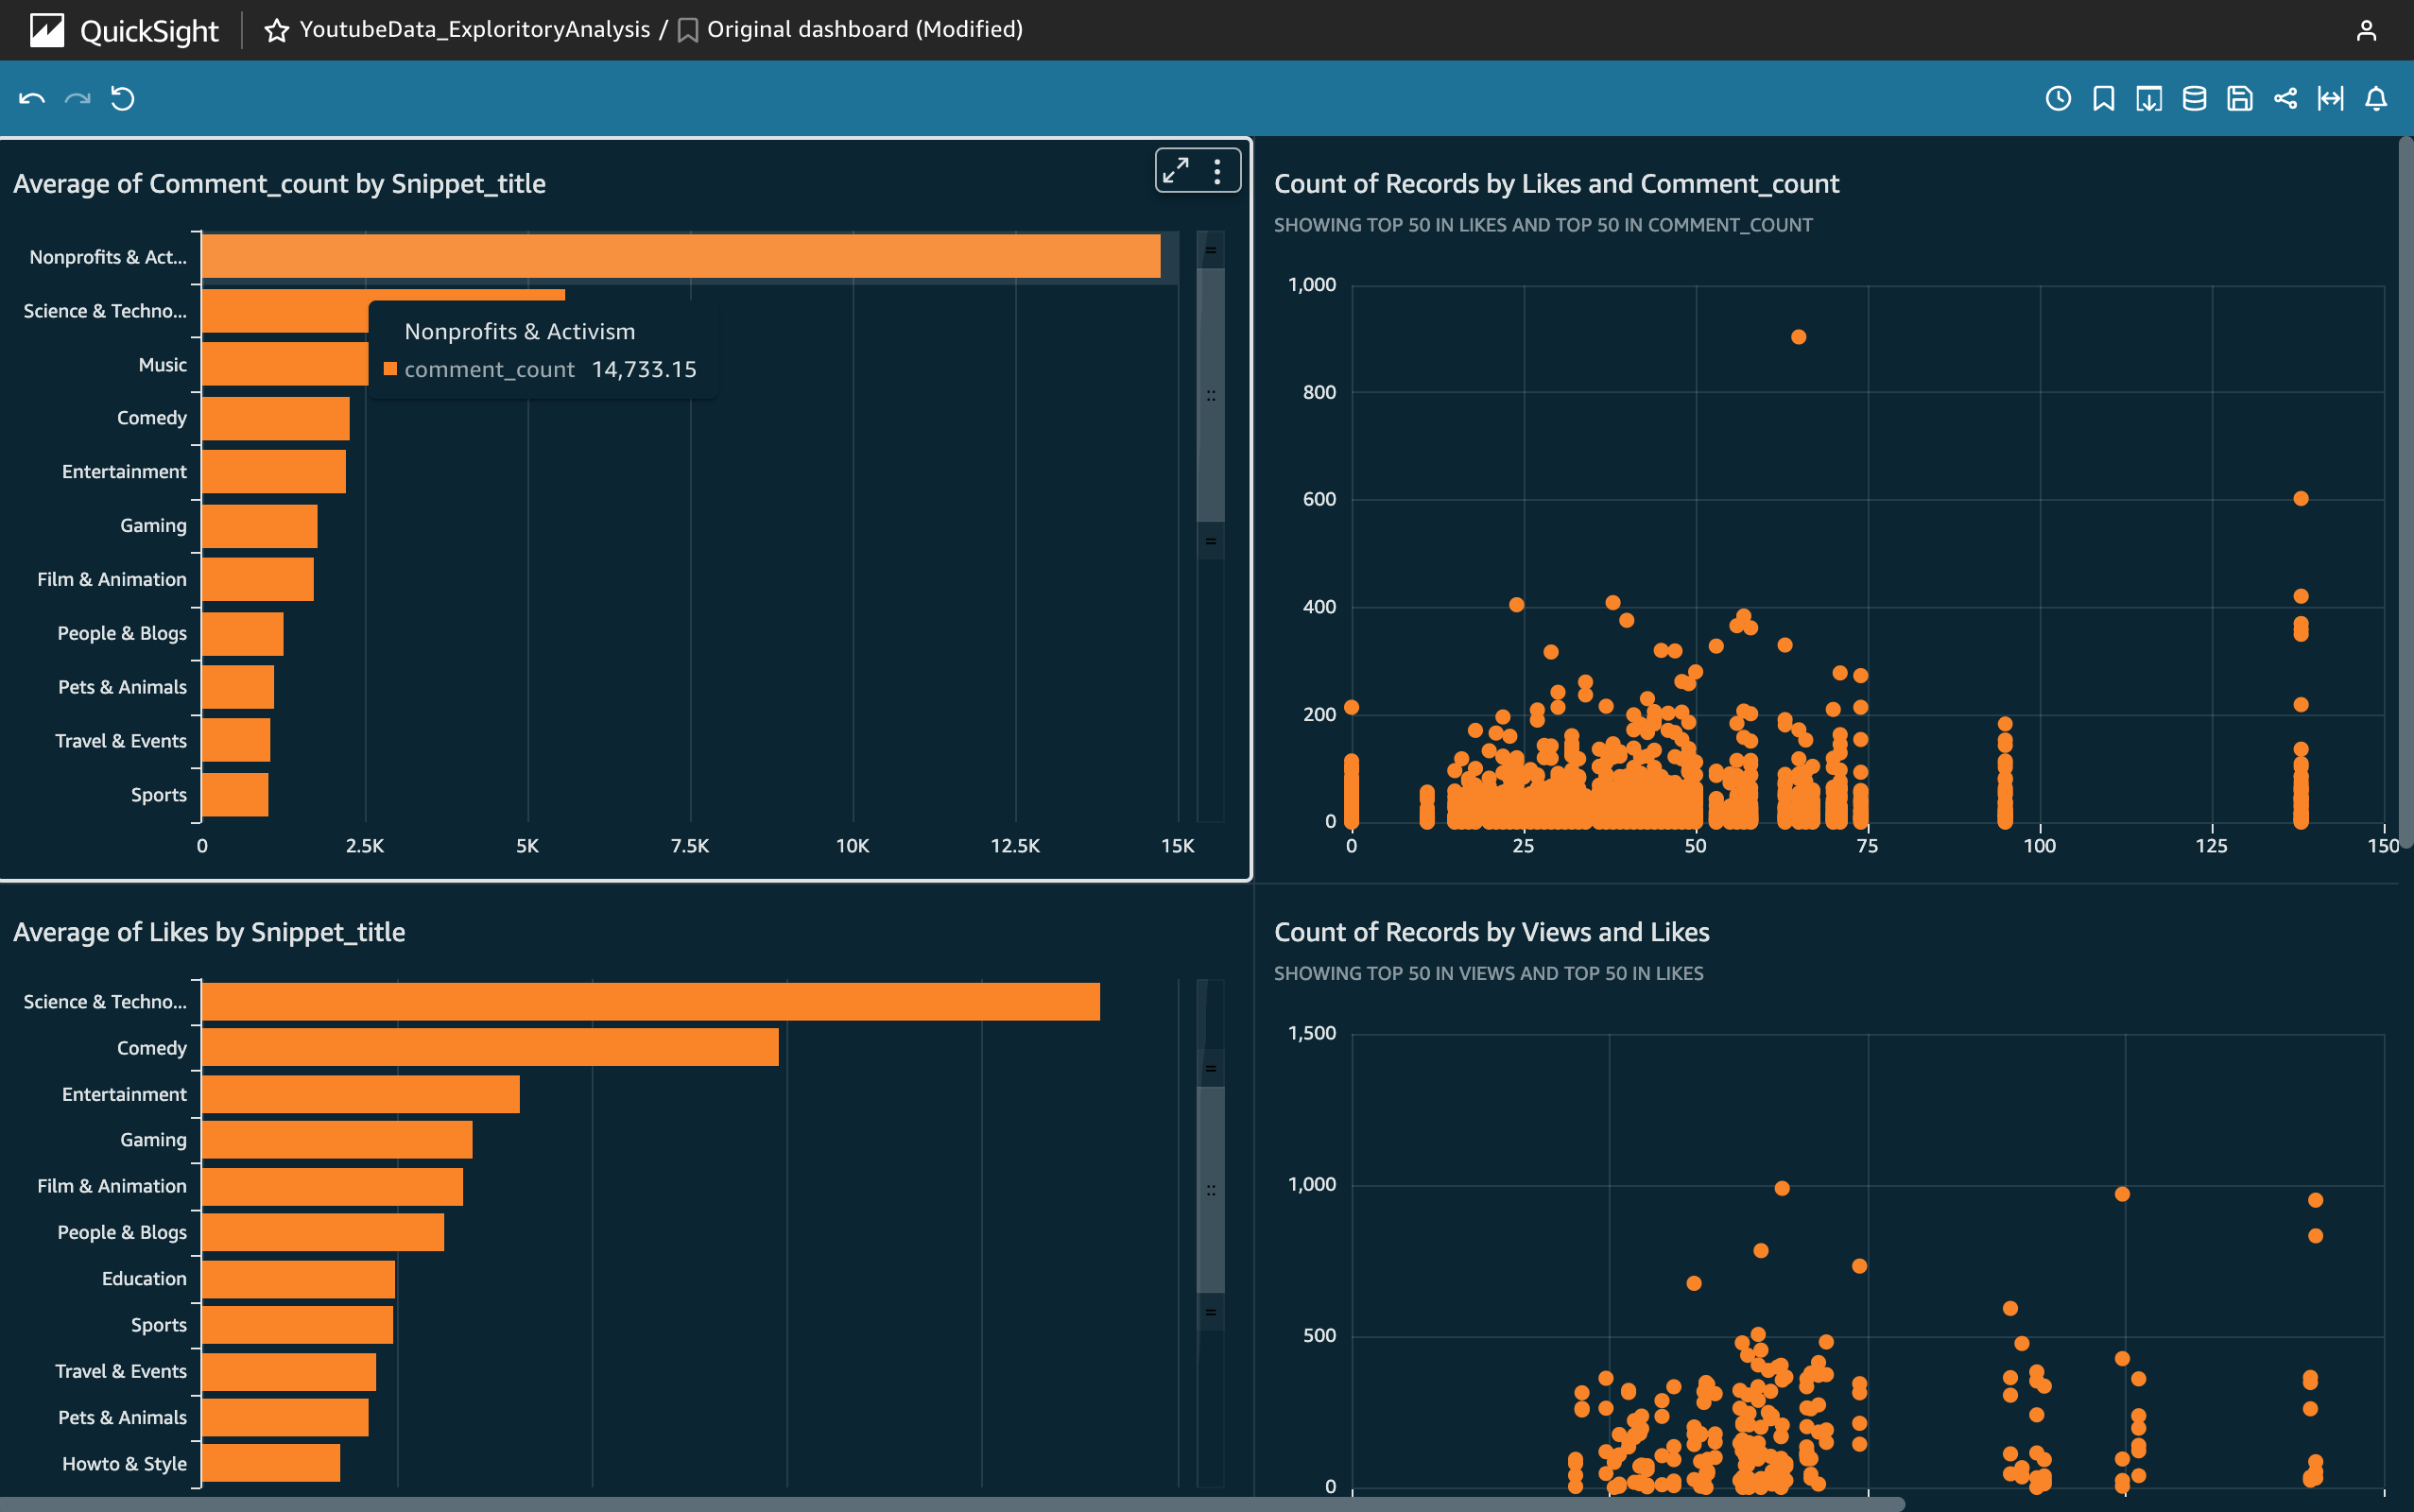


## Conclusion
So now you've completed your ETL pipeline. You created various buckets, assigned permissions and policies, wrote your lambda function, wrote your Glue Job, created triggers and workflows, and visualized your data in a BI tool. Depending on your familiarity with AWS, this may have been a fairly standard pipeline or it may have been an extremely arduous.  
- For those of you who are new to AWS, know that this pipeline is very indicative of the type you may build for a company in the real world. You are already well on your way to becoming an AWS Wizard. Build it and they will come!
- For those of you who are more experience with AWS, remember that this pipeline only scratches the surface of what AWS can do.  There are dozens of other, data storage, manipulation tools, and functionalities that can be leveraged with AWS. Time to start your next project!